In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from pathlib import Path
from typing import Dict, List, Tuple
from tqdm.auto import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

2025-09-19 14:32:41.545062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758272561.680511 2690545 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758272561.723106 2690545 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758272562.030319 2690545 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758272562.030346 2690545 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758272562.030348 2690545 computation_placer.cc:177] computation placer alr

# Electricity Consumption Outlier Detection (Per-Capita, by Socio-Economic Class)

Goal: Detect anomalous (potentially inefficient) household energy usage patterns using an LSTM Autoencoder on 6-hour interval data, **per socio-economic class (SEC)**, and based on **per-capita consumption**.

## Key Changes vs Original Version
1. Uses only households present in both smart meter dataset and socio-economic info file.
2. Converts total household consumption to **per-capita** using `no_of_household_members`.
3. Recategorizes original SEC labels using mapping: { SEC A→SEC A, SEC B→SEC A, SEC C→SEC B, SEC D→SEC C, SEC E→SEC C }.
4. Trains a separate autoencoder for each aggregated SEC class (SEC A, SEC B, SEC C).
5. Performs anomaly detection within each class and exports per-class anomalous household lists.
6. Retains method: sequence reconstruction error → high-error sequences → per-household aggregated error → anomaly threshold.

## High-Level Pipeline
1. Load 6-hour interval smart meter data.
2. Compute incremental kWh (diff) per household, filter date range, pivot to time x household matrix.
3. Load socio-economic & household member data.
4. Inner join: keep only valid households & members > 0.
5. Convert to per-capita consumption.
6. For each aggregated SEC class: scale → build sequences → train autoencoder → detect anomalous households.
7. Save CSV for each SEC class and a combined summary.

## Anomaly Logic Detail
- Sequence reconstruction error = MSE over (time, features).
- Sequence-level anomaly threshold = 98th percentile of reconstruction errors.
- Among anomalous sequences only, compute per-household MSE contribution averaged over anomalous windows + timesteps.
- Household anomaly threshold = 90th percentile of household error distribution (within class).

You can adjust: `SEQUENCE_LENGTH`, `EPOCHS`, `BATCH_SIZE`, `SEQ_ANOMALY_PCT`, `HH_ANOMALY_PCT`.

## 1. Load & Prepare Data (Smart Meter + Socio-Economic Info)

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

# Parameters
DATA_DIR = Path('6hour_interval')  # folder containing smart_6hour_*.csv
HOUSE_INFO_PATHS = [
    Path('wave_1/w1_household_information_and_history.csv'),  # expected file
    Path('wave_1/w1_ac_roster.csv')  # fallback if naming differs
]
DATE_COL = 'DATE'
TIME_COL = 'TIME'
KWH_COL = 'TOTAL_IMPORT (kWh)'
HH_ID_COL_CANDIDATES = ['household_ID', 'household_id', 'hhid', 'HHID']
MEMBERS_COL_CANDIDATES = ['no_of_household_members', 'household_size', 'num_members', 'members']
SEC_COL_CANDIDATES = ['socio_economic_class', 'SEC', 'sec_class', 'socioeconomic_class']

SEQUENCE_LENGTH = 30  # 30 * 6h = 180h (~7.5 days) window
EPOCHS = 40
BATCH_SIZE = 32
SEQ_ANOMALY_PCT = 80
HH_ANOMALY_PCT = 80
SEC_AGG_MAP = { 'SEC A': 'SEC A', 'SEC B': 'SEC A', 'SEC C': 'SEC B', 'SEC D': 'SEC C', 'SEC E': 'SEC C' }
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def first_existing(paths):
    for p in paths:
        if p.exists():
            return p
    raise FileNotFoundError(f'None of the expected household info files found: {paths}')

def pick_first_present(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f'None of the candidate columns {candidates} found in dataframe columns: {df.columns.tolist()}')

# 1. Load smart meter 6-hour interval data
all_data = []
for csv_path in DATA_DIR.glob('*.csv'):
    try:
        df = pd.read_csv(csv_path, low_memory=False)
        all_data.append(df)
    except Exception as e:
        print(f'Skipping {csv_path}: {e}')

if not all_data:
    raise RuntimeError('No 6-hour interval CSV files loaded.')
raw_df = pd.concat(all_data, ignore_index=True)

hh_id_col = pick_first_present(raw_df, HH_ID_COL_CANDIDATES)
cols_needed = [hh_id_col, DATE_COL, TIME_COL, KWH_COL]
missing = [c for c in cols_needed if c not in raw_df.columns]
if missing:
    raise KeyError(f'Missing required columns in smart meter data: {missing}')

raw_df = raw_df[cols_needed].copy()
raw_df[TIME_COL] = raw_df[TIME_COL].astype(str).str.extract(r'(\d{2}:\d{2}:\d{2})')
raw_df['DATETIME'] = pd.to_datetime(raw_df[DATE_COL] + ' ' + raw_df[TIME_COL], errors='coerce')
raw_df[KWH_COL] = pd.to_numeric(raw_df[KWH_COL], errors='coerce')
raw_df = raw_df.dropna(subset=['DATETIME'])
raw_df = raw_df.sort_values([hh_id_col, 'DATETIME'])

# Convert cumulative import to interval consumption (diff per 6h)
raw_df[KWH_COL] = raw_df.groupby(hh_id_col)[KWH_COL].diff()

# ⚡️ No date filtering → keep all available data
# (was: raw_df = raw_df[(raw_df['DATETIME'] >= START_DATE) & (raw_df['DATETIME'] <= END_DATE)].copy())

# Floor to 6h and deduplicate (keep first per 6h bucket)
raw_df['DATETIME'] = raw_df['DATETIME'].dt.floor('6h')
raw_df = raw_df.drop_duplicates(subset=[hh_id_col, 'DATETIME'])

# Pivot to time x household matrix
pivot_df = raw_df.pivot(index='DATETIME', columns=hh_id_col, values=KWH_COL)
pivot_df = pivot_df.sort_index()

# 🔹 Fill missing values more aggressively
pivot_df = pivot_df.ffill().bfill()  # forward fill then backfill

# 🔹 Keep households with at least 40% data coverage
min_required = int(0.4 * len(pivot_df))  # 80% of rows must be non-NaN
pivot_df = pivot_df.dropna(axis=1, thresh=min_required)

print(f'Initial households after cleaning: {pivot_df.shape[1]}')

# 2. Load socio-economic & membership info
info_path = first_existing(HOUSE_INFO_PATHS)
house_info = pd.read_csv(info_path, low_memory=False)
hh_info_id_col = pick_first_present(house_info, HH_ID_COL_CANDIDATES)
members_col = pick_first_present(house_info, MEMBERS_COL_CANDIDATES)
sec_col = pick_first_present(house_info, SEC_COL_CANDIDATES)

house_info = house_info[[hh_info_id_col, members_col, sec_col]].copy()
house_info[members_col] = pd.to_numeric(house_info[members_col], errors='coerce')
house_info = house_info.dropna(subset=[members_col, sec_col])
house_info = house_info[house_info[members_col] > 0]  # valid member counts

# Apply SEC aggregation map (case-insensitive safe)
house_info[sec_col] = house_info[sec_col].astype(str).str.strip()
house_info['SEC_AGG'] = house_info[sec_col].map(lambda x: SEC_AGG_MAP.get(x, np.nan))
house_info = house_info.dropna(subset=['SEC_AGG'])

# Intersect households present in both data sources
common_households = sorted(set(pivot_df.columns).intersection(set(house_info[hh_info_id_col])))
pivot_df = pivot_df[common_households].copy()
house_info = house_info[house_info[hh_info_id_col].isin(common_households)].copy()
print(f'Households after intersection: {pivot_df.shape[1]}')

# 3. Compute per-capita consumption
members_map = dict(zip(house_info[hh_info_id_col], house_info[members_col]))
members_series = pd.Series(members_map)
per_capita_df = pivot_df / members_series  # automatic alignment by column labels
per_capita_df = per_capita_df.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='any')

# Re-filter house_info to those still present
house_info = house_info[house_info[hh_info_id_col].isin(per_capita_df.columns)].copy()
print(f'Households after per-capita cleanup: {per_capita_df.shape[1]}')

# Summary counts per aggregated SEC
sec_counts = house_info.groupby('SEC_AGG')[hh_info_id_col].nunique().to_dict()
print('Household counts per aggregated SEC:', sec_counts)


Initial households after cleaning: 2950
Households after intersection: 1438
Households after per-capita cleanup: 1438
Household counts per aggregated SEC: {'SEC A': 681, 'SEC B': 489, 'SEC C': 268}


In [3]:
# Earliest date
start_date = pivot_df.index.min()

# Latest date
end_date = pivot_df.index.max()

print(f"Data range: {start_date} to {end_date}")

Data range: 2023-01-01 00:00:00 to 2024-12-31 18:00:00


In [4]:
# Overall %
missing_pct_total = pivot_df.isna().mean().mean() * 100
print(f"Overall missing percentage: {missing_pct_total:.2f}%")

# Per household %
missing_pct_per_household = pivot_df.isna().mean() * 100
print("Missing percentage per household:")
print(missing_pct_per_household)

Overall missing percentage: 0.00%
Missing percentage per household:
household_ID
ID0013    0.0
ID0018    0.0
ID0041    0.0
ID0043    0.0
ID0052    0.0
         ... 
ID3817    0.0
ID3818    0.0
ID3819    0.0
ID3820    0.0
ID3822    0.0
Length: 1438, dtype: float64


## 2. Helper Functions (Sequence Builder, Model Factory, Anomaly Detection)

In [5]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.model_selection import train_test_split


def build_sequences(array_2d: np.ndarray, seq_len: int) -> np.ndarray:
    """
    Convert a 2D time-series array into overlapping sequences.

    Parameters
    ----------
    array_2d : np.ndarray
        Shape (timesteps, n_features). Each column = household, each row = time step.
    seq_len : int
        Sequence length (number of timesteps per sequence).

    Returns
    -------
    np.ndarray
        Shape (num_sequences, seq_len, n_features).
    """
    sequences = []
    for i in range(len(array_2d) - seq_len + 1):
        sequences.append(array_2d[i:i + seq_len])
    return np.array(sequences)


def build_autoencoder(n_features: int, seq_len: int, latent_units: int = 128) -> Model:
    """
    Build an LSTM autoencoder for sequence reconstruction.

    Parameters
    ----------
    n_features : int
        Number of features (households).
    seq_len : int
        Sequence length.
    latent_units : int
        Number of LSTM units in encoder/decoder.

    Returns
    -------
    keras.Model
        Compiled LSTM autoencoder.
    """
    inp = Input(shape=(seq_len, n_features))
    encoded = LSTM(latent_units, activation='relu', return_sequences=False)(inp)
    decoded = RepeatVector(seq_len)(encoded)
    decoded = LSTM(latent_units, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(n_features))(decoded)

    model = Model(inp, decoded)
    model.compile(optimizer='adam', loss='mse')
    return model


def detect_anomalies(sequences: np.ndarray, model: Model, seq_pct: float, hh_pct: float,
                     epochs: int, batch_size: int, random_state: int = 42):
    """
    Train autoencoder, compute reconstruction errors, and detect anomalous sequences/households.

    Parameters
    ----------
    sequences : np.ndarray
        Input sequences of shape (num_sequences, seq_len, n_features).
    model : keras.Model
        Autoencoder model.
    seq_pct : float
        Percentile threshold for anomalous sequences (e.g., 80 = top 20%).
    hh_pct : float
        Percentile threshold for anomalous households among anomalous sequences.
    epochs : int
        Number of training epochs.
    batch_size : int
        Training batch size.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    dict
        {
            'history': training history,
            'sequence_errors': np.ndarray,
            'sequence_threshold': float,
            'sequence_anomaly_mask': np.ndarray[bool],
            'household_errors': np.ndarray,
            'household_threshold': float,
            'household_anom_indices': np.ndarray[int]
        }
    """
    # Train/validation split
    X_train, X_val = train_test_split(sequences, test_size=0.2, random_state=random_state)

    history = model.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, X_val),
        verbose=0
    )

    # Reconstruction
    reconstructed = model.predict(sequences, verbose=0)

    # Sequence-level errors
    seq_errors = np.mean(np.square(sequences - reconstructed), axis=(1, 2))
    seq_threshold = np.percentile(seq_errors, seq_pct)
    seq_anom_mask = seq_errors > seq_threshold

    # Household-level errors (among anomalous sequences only)
    anomalous_sequences = sequences[seq_anom_mask]
    anomalous_recon = reconstructed[seq_anom_mask]
    per_hh_errors = np.square(anomalous_sequences - anomalous_recon)  # (num_anom_seq, seq_len, n_features)
    hh_errors = per_hh_errors.mean(axis=(0, 1))  # average over sequences + timesteps
    hh_threshold = np.percentile(hh_errors, hh_pct)
    hh_anom_idx = np.where(hh_errors > hh_threshold)[0]

    return {
        'history': history,
        'sequence_errors': seq_errors,
        'sequence_threshold': seq_threshold,
        'sequence_anomaly_mask': seq_anom_mask,
        'household_errors': hh_errors,
        'household_threshold': hh_threshold,
        'household_anom_indices': hh_anom_idx
    }


## 3. Train Per SEC Class Autoencoders and Detect Anomalous Households

In [6]:
# ==========================
# Imports
# ==========================
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# ==========================
# Config
# ==========================
EPOCHS = 20
BATCH_SIZE = 32
SEQUENCE_LENGTH = 30
SEQ_ANOMALY_PCT = 80
HH_ANOMALY_PCT = 80
RANDOM_STATE = 42

# ==========================
# Functions
# ==========================
def build_sequences(array_2d: np.ndarray, seq_len: int) -> np.ndarray:
    """Convert 2D array (time, features) into rolling window sequences."""
    sequences = []
    for i in range(len(array_2d) - seq_len + 1):
        sequences.append(array_2d[i:i + seq_len])
    return np.array(sequences)

def build_autoencoder(n_features: int, seq_len: int, latent_units: int = 128) -> Model:
    """Build LSTM sequence autoencoder."""
    inp = Input(shape=(seq_len, n_features))
    encoded = LSTM(latent_units, activation='relu', return_sequences=False)(inp)
    decoded = RepeatVector(seq_len)(encoded)
    decoded = LSTM(latent_units, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(n_features))(decoded)
    model = Model(inp, decoded)
    model.compile(optimizer='adam', loss='mse')
    return model

def detect_anomalies(sequences: np.ndarray, model: Model, seq_pct: float, hh_pct: float, random_state: int = 42):
    """Train model, detect anomalous sequences & households."""
    X_train, X_val = train_test_split(sequences, test_size=0.2, random_state=random_state)
    history = model.fit(
        X_train, X_train,
        epochs=EPOCHS,          # use global constant
        batch_size=BATCH_SIZE,  # use global constant
        validation_data=(X_val, X_val),
        verbose=0
    )

    reconstructed = model.predict(sequences, verbose=0)
    seq_errors = np.mean(np.square(sequences - reconstructed), axis=(1, 2))

    # Threshold for anomalous sequences
    seq_threshold = np.percentile(seq_errors, seq_pct)
    seq_anom_mask = seq_errors > seq_threshold

    anomalous_sequences = sequences[seq_anom_mask]
    anomalous_recon = reconstructed[seq_anom_mask]

    # Per-household contribution
    per_hh_errors = np.square(anomalous_sequences - anomalous_recon)
    hh_errors = per_hh_errors.mean(axis=(0, 1))  # average over sequences & timesteps
    hh_threshold = np.percentile(hh_errors, hh_pct)
    hh_anom_idx = np.where(hh_errors > hh_threshold)[0]

    return {
        'history': history,
        'sequence_errors': seq_errors,
        'sequence_threshold': seq_threshold,
        'sequence_anomaly_mask': seq_anom_mask,
        'household_errors': hh_errors,
        'household_threshold': hh_threshold,
        'household_anom_indices': hh_anom_idx
    }

# ==========================
# Main Loop (per SEC_AGG class)
# ==========================
results_summary = []
per_class_anomalies = {}

for agg_sec in sorted(house_info['SEC_AGG'].unique()):
    print(f'\n=== Processing {agg_sec} ===')
    hh_ids = house_info.loc[house_info['SEC_AGG'] == agg_sec, hh_info_id_col].unique().tolist()
    class_df = per_capita_df[hh_ids].copy()

    # Scale each household (feature) across time
    scaler = MinMaxScaler()
    norm_vals = scaler.fit_transform(class_df.values)  # shape (time, households)

    sequences = build_sequences(norm_vals, SEQUENCE_LENGTH)
    if sequences.shape[0] < 50:
        print(f'Warning: Only {sequences.shape[0]} sequences for {agg_sec}; results may be unstable.')

    model = build_autoencoder(
        n_features=norm_vals.shape[1],
        seq_len=SEQUENCE_LENGTH,
        latent_units=min(128, max(16, norm_vals.shape[1] * 2))
    )

    det = detect_anomalies(sequences, model, SEQ_ANOMALY_PCT, HH_ANOMALY_PCT, random_state=RANDOM_STATE)
    anom_households = [hh_ids[i] for i in det['household_anom_indices']]
    per_class_anomalies[agg_sec] = anom_households

    # Save anomalies for this SEC class
    out_csv = f"anomalous_households_autoencoder_{agg_sec.replace(' ', '_')}.csv"
    pd.DataFrame({
        'household_ID': anom_households,
        'SEC_AGG': agg_sec,
        'per_capita': True
    }).to_csv(out_csv, index=False)

    print(f'Anomalous households in {agg_sec}: {len(anom_households)} (saved to {out_csv})')
    results_summary.append({
        'SEC_AGG': agg_sec,
        'total_households': len(hh_ids),
        'anomalous_households': len(anom_households),
        'sequence_threshold': float(det['sequence_threshold']),
        'household_threshold': float(det['household_threshold'])
    })

# ==========================
# Save Summary
# ==========================
summary_df = pd.DataFrame(results_summary)
summary_df.to_csv('anomalous_households_autoencoder_summary_by_sec.csv', index=False)

print('\nSummary by SEC class:')
print(summary_df)



=== Processing SEC A ===


I0000 00:00:1758272622.029091 2690545 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3341 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:65:00.0, compute capability: 8.9
I0000 00:00:1758272625.789922 2690655 service.cc:152] XLA service 0x5594d99d5b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758272625.789942 2690655 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-09-19 14:33:45.917069: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758272626.449207 2690655 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-09-19 14:33:47.675185: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_113', 12 b

Anomalous households in SEC A: 136 (saved to anomalous_households_autoencoder_SEC_A.csv)

=== Processing SEC B ===


2025-09-19 14:34:28.244746: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 12 bytes spill stores, 12 bytes spill loads

2025-09-19 14:34:28.268326: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 20 bytes spill stores, 20 bytes spill loads

2025-09-19 14:34:28.362041: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 12 bytes spill stores, 12 bytes spill loads

2025-09-19 14:34:33.741826: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 20 bytes spill stores, 20 bytes spill loads

2025-09-19 14:34:33.765690: I external/local

Anomalous households in SEC B: 98 (saved to anomalous_households_autoencoder_SEC_B.csv)

=== Processing SEC C ===


2025-09-19 14:35:03.352331: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 12 bytes spill stores, 12 bytes spill loads

2025-09-19 14:35:03.355920: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 8 bytes spill stores, 8 bytes spill loads

2025-09-19 14:35:03.483634: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 4 bytes spill stores, 4 bytes spill loads

2025-09-19 14:35:08.906340: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 4 bytes spill stores, 4 bytes spill loads

2025-09-19 14:35:09.020616: I external/local_xla/x

Anomalous households in SEC C: 54 (saved to anomalous_households_autoencoder_SEC_C.csv)

Summary by SEC class:
  SEC_AGG  total_households  anomalous_households  sequence_threshold  \
0   SEC A               681                   136            0.002898   
1   SEC B               489                    98            0.002086   
2   SEC C               268                    54            0.002343   

   household_threshold  
0             0.005443  
1             0.004904  
2             0.005447  


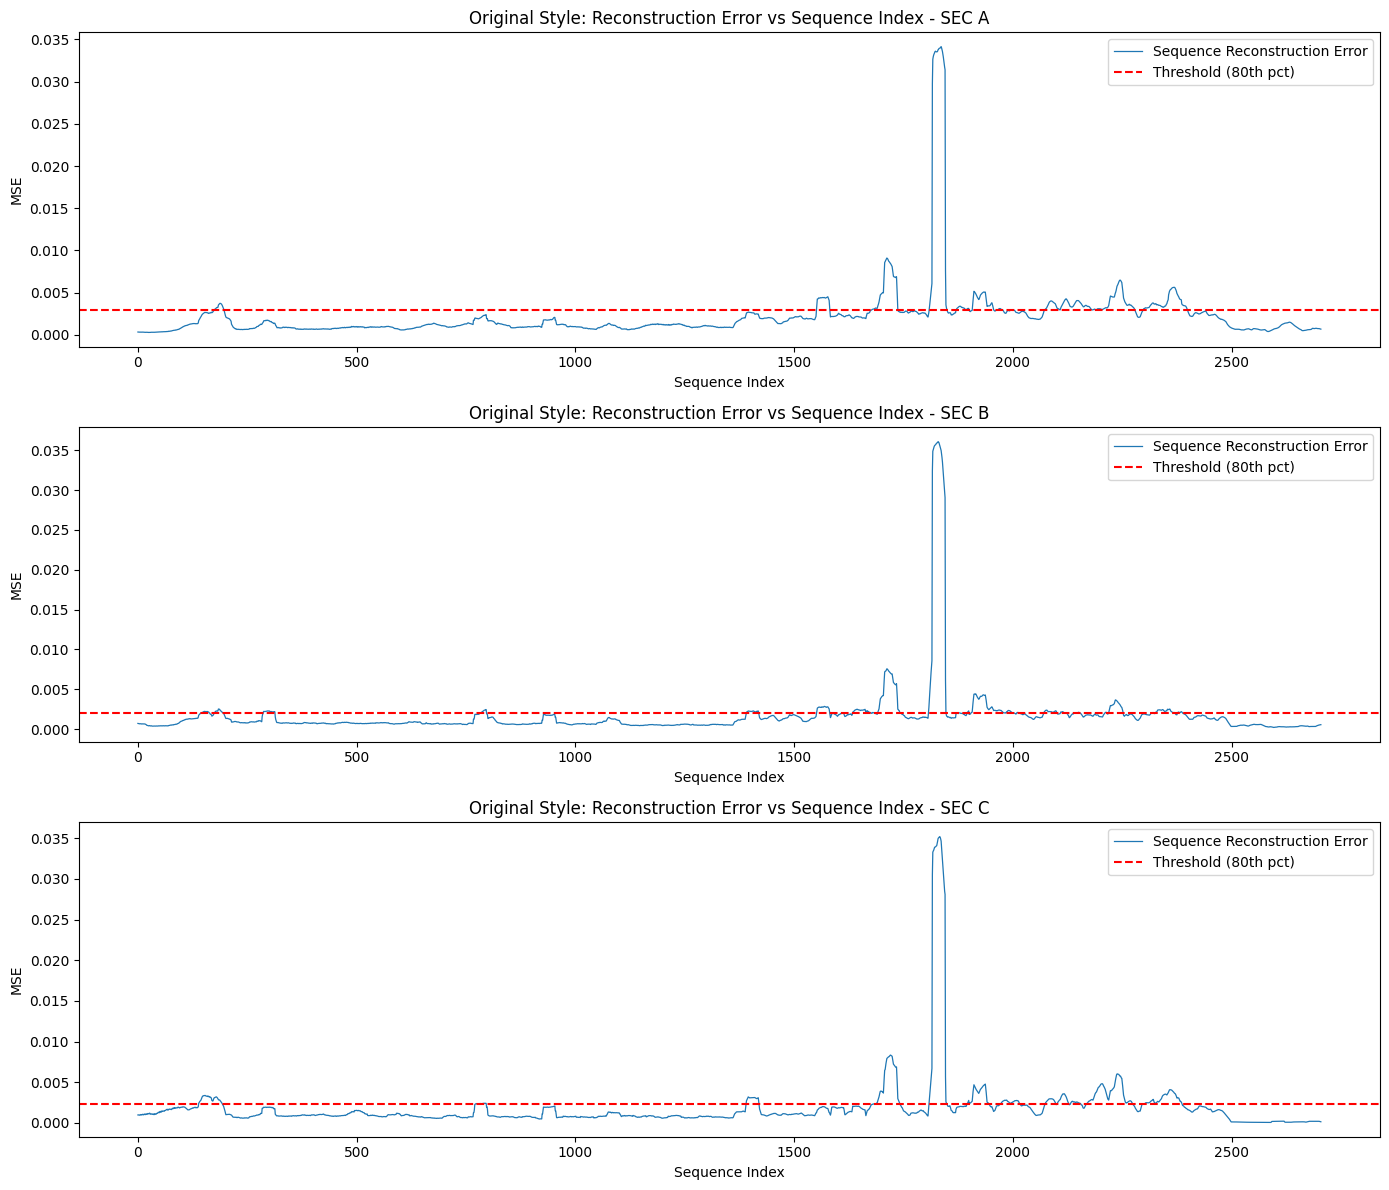

In [7]:
# Original-style reconstruction error line plots with horizontal threshold for ALL SEC classes
# (Keeps existing histogram cell unchanged.)
from math import ceil
sec_classes = sorted(house_info['SEC_AGG'].unique())
fig_rows = len(sec_classes)
plt.figure(figsize=(14,4*fig_rows))
plot_index = 1
for agg_sec in sec_classes:
    hh_ids = house_info.loc[house_info['SEC_AGG'] == agg_sec, hh_info_id_col].unique().tolist()
    class_df = per_capita_df[hh_ids].copy()
    scaler = MinMaxScaler()
    norm_vals = scaler.fit_transform(class_df.values)
    sequences = build_sequences(norm_vals, SEQUENCE_LENGTH)
    model = build_autoencoder(n_features=norm_vals.shape[1], seq_len=SEQUENCE_LENGTH, latent_units=min(128, max(16, norm_vals.shape[1]*2)))
    det = detect_anomalies(sequences, model, SEQ_ANOMALY_PCT, HH_ANOMALY_PCT, random_state=RANDOM_STATE)
    seq_errors = det['sequence_errors']
    seq_threshold = det['sequence_threshold']
    plt.subplot(fig_rows,1,plot_index)
    plt.plot(seq_errors, label='Sequence Reconstruction Error', linewidth=0.9)
    plt.axhline(seq_threshold, color='red', linestyle='--', label=f'Threshold ({SEQ_ANOMALY_PCT}th pct)')
    plt.title(f'Original Style: Reconstruction Error vs Sequence Index - {agg_sec}')
    plt.xlabel('Sequence Index')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')
    plot_index += 1
plt.tight_layout()
plt.show()

In [8]:
combined_rows = []
for sec_class, hh_list in per_class_anomalies.items():
    for h in hh_list:
        combined_rows.append({'household_ID': h, 'SEC_AGG': sec_class})
combined_df = pd.DataFrame(combined_rows).drop_duplicates()
combined_df.to_csv('anomalous_households_autoencoder_per_capita_all_classes.csv', index=False)
print(f'Total anomalous households (unique across classes): {combined_df.shape[0]}')
display(combined_df.head())

Total anomalous households (unique across classes): 288


,household_ID,SEC_AGG
0,ID0043,SEC A
1,ID0113,SEC A
2,ID0135,SEC A
3,ID0154,SEC A
4,ID0177,SEC A


In [11]:
# Load and engineer appliance features (counts & average weekly usage hours per appliance_type)
import seaborn as sns
APPLIANCE_PATH_CANDIDATES = [Path('wave_1/w1_appliance.csv'), Path('wave_1/w1_appliances.csv'), Path('wave_1/appliance.csv')]
def first_existing_path(paths):
    for p in paths:
        if p.exists():
            return p
    raise FileNotFoundError(f'None of expected appliance files found: {paths}')
appliance_path = first_existing_path(APPLIANCE_PATH_CANDIDATES)
app_df = pd.read_csv(appliance_path, low_memory=False)
# Standardize column names
app_df.columns = [c.strip().lower().replace(' ', '_') for c in app_df.columns]
# Identify columns (robust to naming)
APP_HH_COL = next(c for c in app_df.columns if 'household' in c and 'id' in c)
APP_TYPE_COL = next(c for c in app_df.columns if 'appliance_type' in c or c.endswith('type'))
APP_ID_COL = next(c for c in app_df.columns if c.startswith('appliance_id') or c=='appliance_id')
HOURS_COL = next((c for c in app_df.columns if 'hours' in c and 'week' in c), None)
if HOURS_COL is None: raise KeyError('Could not locate hours usage column in appliance file.')
app_df[HOURS_COL] = pd.to_numeric(app_df[HOURS_COL], errors='coerce')
# Aggregate per household + appliance_type
appliance_stats = (app_df.groupby([APP_HH_COL, APP_TYPE_COL])
                       .agg(count=(APP_ID_COL,'nunique'), mean_hours=(HOURS_COL,'mean'))
                       .reset_index())
# Pivot counts
counts_wide = appliance_stats.pivot(index=APP_HH_COL, columns=APP_TYPE_COL, values='count')
counts_wide.columns = [f'count__{c}' for c in counts_wide.columns]
# Pivot mean hours
hours_wide = appliance_stats.pivot(index=APP_HH_COL, columns=APP_TYPE_COL, values='mean_hours')
hours_wide.columns = [f'hours__{c}' for c in hours_wide.columns]
appliance_features = counts_wide.join(hours_wide, how='outer')
# Restrict to modeled households (intersection with full_info if available else house_info)
if 'full_info' in globals():
    modeled_ids = set(full_info[hh_col2].astype(str))
    idx_name = appliance_features.index.name
    appliance_features = appliance_features[appliance_features.index.astype(str).isin(modeled_ids)]
else:
    modeled_ids = set(house_info[hh_info_id_col].astype(str))
    appliance_features = appliance_features[appliance_features.index.astype(str).isin(modeled_ids)]
# Merge with anomaly labels + SEC_AGG
if 'full_info' in globals():
    merged_app = full_info.set_index(hh_col2).join(appliance_features, how='left')
else:
    # Build anomaly label fallback
    anomaly_csv = 'anomalous_households_autoencoder_per_capita_all_classes.csv'
    anomalies_set = set(pd.read_csv(anomaly_csv)['household_ID'].astype(str)) if os.path.exists(anomaly_csv) else set()
    tmp_df = house_info[[hh_info_id_col,'SEC_AGG']].copy()
    tmp_df['anomalous'] = tmp_df[hh_info_id_col].astype(str).isin(anomalies_set)
    merged_app = tmp_df.set_index(hh_info_id_col).join(appliance_features, how='left')
print('Appliance feature matrix shape:', merged_app.shape)
merged_app.head(3)

Appliance feature matrix shape: (1438, 156)


,SEC_AGG,anomalous,count__Air fryer,count__Bluetooth Speakers,count__CCTV camera systems,count__Camera (that needs to be charged using electricity),count__Clothes dryer,count__Coffee maker,count__Computers,count__DVD / VCD,...,hours__Routers,hours__Scanner,hours__Separate Freezer,hours__Sound systems (Subwoofer)/Stereo,hours__TV,hours__TV antenna,hours__Toaster / Sandwich toaster,hours__Toys with re-chargeable batteries,hours__Waffle maker,hours__Washing Machine
household_ID,,,,,,,,,,,,,,,,,,,,,
ID0013,SEC A,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,0.50
ID0018,SEC A,False,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4.50
ID0041,SEC A,False,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.0,NaN,0.0,NaN,NaN,1.05


In [12]:
# --- Add AC, Fan, Bulb counts & weekly average hours (day+night) into appliance_features ---
from pathlib import Path
import pandas as pd, numpy as np

def first_existing_path(paths):
    for p in paths:
        if p.exists():
            return p
    return None  # return None (silent) if not found

def _load_special(paths, device_label, day_kw='day', night_kw='night'):
    path = first_existing_path(paths)
    if path is None:
        print(f'No file found for {device_label}; skipping.')
        return None
    df = pd.read_csv(path, low_memory=False)
    # standardize cols
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
    # pick columns
    hh_col = next(c for c in df.columns if 'household' in c and 'id' in c)
    cand_ids = [c for c in df.columns if c.endswith('_id') and c != hh_col]
    device_id_col = cand_ids[0] if cand_ids else None
    day_cols = [c for c in df.columns if day_kw in c and 'hour' in c]
    night_cols = [c for c in df.columns if night_kw in c and 'hour' in c]
    day_col = max(day_cols, key=len) if day_cols else None
    night_col = max(night_cols, key=len) if night_cols else None
    if day_col is None or night_col is None:
        print(f'Could not identify day/night hour columns for {device_label}; skipping.')
        return None
    for c in [day_col, night_col]:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df['total_weekly_hours'] = df[day_col].fillna(0) + df[night_col].fillna(0)
    # Optional energy if wattage column exists
    wattage_col = next((c for c in df.columns if 'wattage' in c), None)
    if wattage_col:
        df[wattage_col] = pd.to_numeric(df[wattage_col], errors='coerce')
        df['weekly_energy_kwh'] = (df[wattage_col].fillna(0) * df['total_weekly_hours']) / 1000.0
    grp = df.groupby(hh_col)
    if device_id_col:
        count_series = grp[device_id_col].nunique()
    else:
        count_series = grp.size()
    mean_hours = grp['total_weekly_hours'].mean()
    data = {f'count__{device_label}': count_series, f'hours__{device_label}': mean_hours}
    if 'weekly_energy_kwh' in df.columns:
        data[f'energy__{device_label}'] = grp['weekly_energy_kwh'].mean()
    out = pd.DataFrame(data)
    return out

FAN_PATHS = [Path('fan.csv'), Path('fans.csv'), Path('wave_1/w1_fan_roster.csv'), Path('wave_1/w1_fans.csv'), Path('wave_1/fan.csv'), Path('wave_1/fans.csv')]
AC_PATHS = [Path('ac.csv'), Path('acs.csv'), Path('/Users/ediritillekegeranushinimthara/Library/CloudStorage/OneDrive-LIRNEasia/Ranushi/Lacuna/vscode/wave_1/w1_ac_roster.csv'), Path('wave_1/w1_acs.csv'), Path('wave_1/ac.csv'), Path('wave_1/acs.csv')]
LIGHT_PATHS = [Path('light.csv'), Path('lights.csv'), Path('bulb.csv'), Path('bulbs.csv'), Path('/Users/ediritillekegeranushinimthara/Library/CloudStorage/OneDrive-LIRNEasia/Ranushi/Lacuna/vscode/wave_1/w1_light_roster.csv'), Path('wave_1/w1_lights.csv'), Path('wave_1/w1_bulb.csv'), Path('wave_1/w1_bulbs.csv'), Path('wave_1/light.csv'), Path('wave_1/lights.csv'), Path('wave_1/bulb.csv'), Path('wave_1/bulbs.csv')]

special_dfs = []
fan_df = _load_special(FAN_PATHS, 'fan')
if fan_df is not None: special_dfs.append(fan_df)
ac_df = _load_special(AC_PATHS, 'ac')
if ac_df is not None: special_dfs.append(ac_df)
bulb_df = _load_special(LIGHT_PATHS, 'bulb')
if bulb_df is not None: special_dfs.append(bulb_df)

if special_dfs:
    for df_ in special_dfs: df_.index = df_.index.astype(str)
    special_features = special_dfs[0]
    for add in special_dfs[1:]:
        special_features = special_features.join(add, how='outer')
    if 'appliance_features' in globals():
        appliance_features.index = appliance_features.index.astype(str)
        appliance_features = appliance_features.join(special_features, how='left')
    else:
        appliance_features = special_features.copy()
    if 'merged_app' in globals():
        merged_app = merged_app.join(special_features, how='left')
    print('Added special device features. New columns added:', list(special_features.columns))
else:
    print('No special device files found; nothing added.')

if 'appliance_features' in globals():
    new_cols = [c for c in appliance_features.columns if any(x in c for x in ['count__ac','count__bulb','count__fan','hours__ac','hours__bulb','hours__fan','energy__ac','energy__bulb','energy__fan'])]
    display(appliance_features[new_cols].head()) if new_cols else print('No new AC/Bulb/Fan columns to display.')

Added special device features. New columns added: ['count__fan', 'hours__fan', 'count__ac', 'hours__ac', 'energy__ac', 'count__bulb', 'hours__bulb', 'energy__bulb']


,count__fan,hours__fan,count__ac,hours__ac,energy__ac,count__bulb,hours__bulb,energy__bulb
household_id,,,,,,,,
ID0013,5.0,1.333333,NaN,NaN,NaN,9.0,2.300000,0.017600
ID0018,6.0,27.000000,1.0,56.00,112.0,20.0,17.234043,0.172340
ID0041,7.0,8.000000,1.0,21.00,0.0,15.0,1.728814,0.000000
ID0043,7.0,7.000000,4.0,36.75,0.0,18.0,7.402453,0.040195
ID0052,4.0,31.250000,NaN,NaN,NaN,7.0,20.222222,0.256667


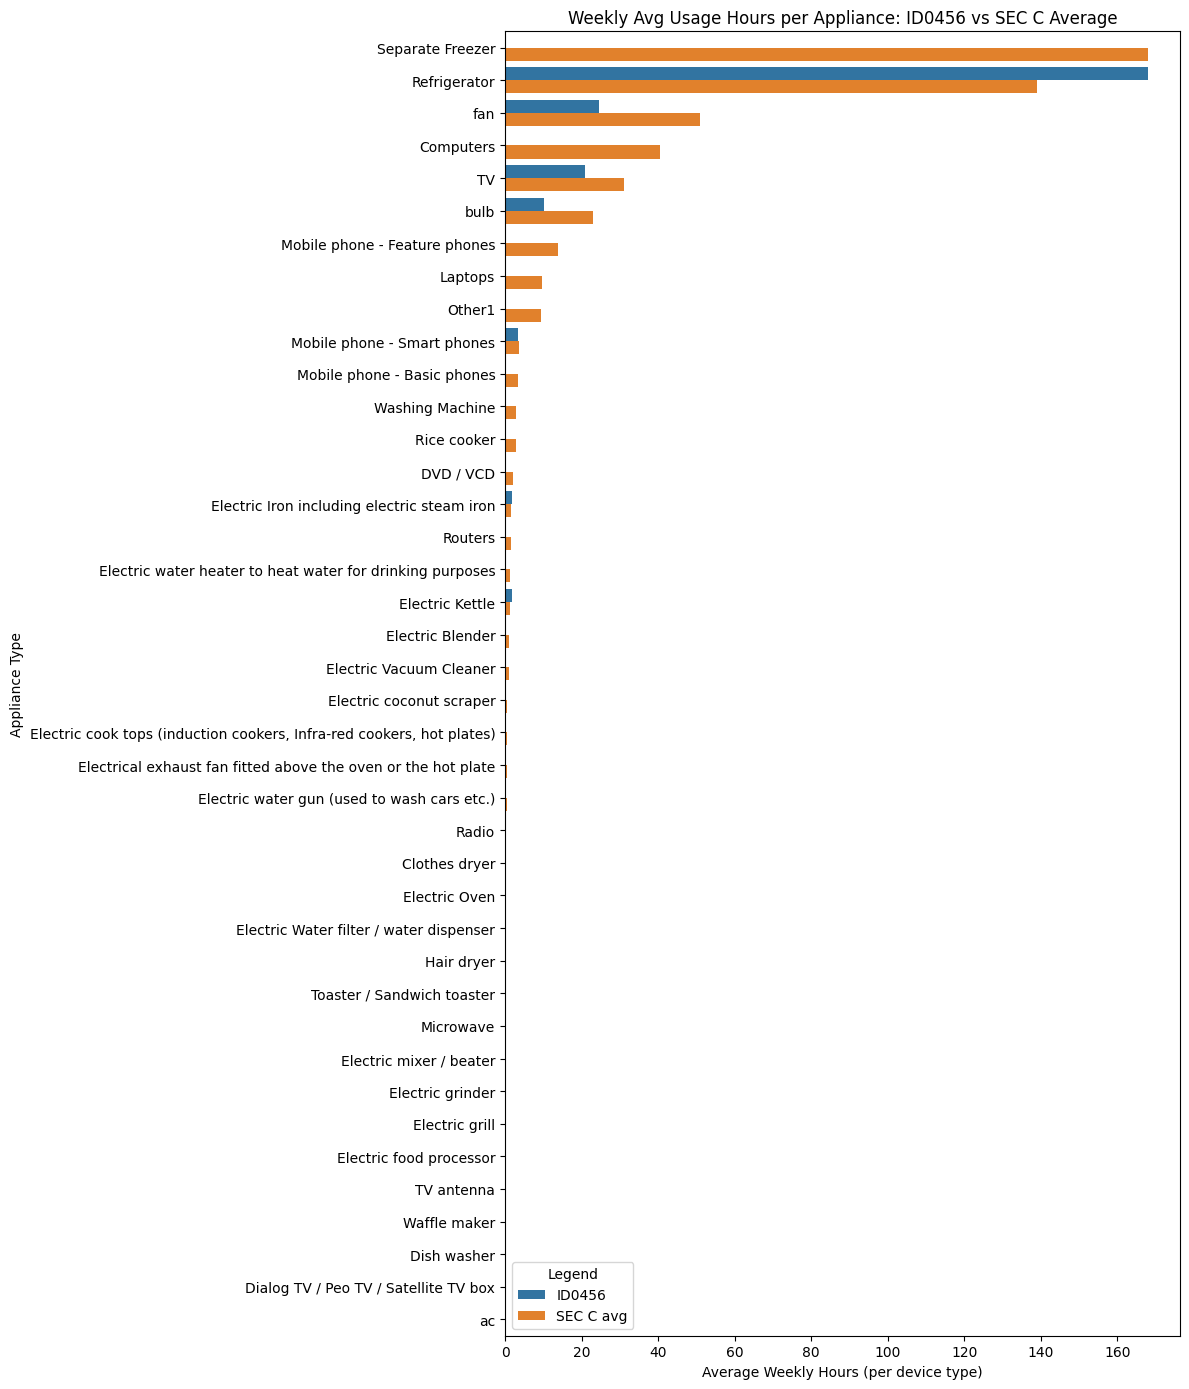

,appliance,household_hours,class_avg_hours
69,Separate Freezer,NaN,168.000000
64,Refrigerator,168.000,139.071038
77,fan,24.500,50.897337
6,Computers,NaN,40.400000
71,TV,21.000,31.120960
79,bulb,10.082,23.081109
54,Mobile phone - Feature phones,NaN,13.833333
50,Laptops,NaN,9.695652
58,Other1,NaN,9.375000
55,Mobile phone - Smart phones,3.300,3.686173


In [13]:
# Plot household ID0456 weekly avg hours per appliance vs its SEC_AGG class average
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
target_id_raw = 'ID0456'
def _find_actual_id(idx, target):
    # case-insensitive match
    lc_map = {str(i).lower(): i for i in idx}
    return lc_map.get(target.lower())
# Ensure we have merged_app with SEC_AGG + hours__* columns
if 'merged_app' not in globals():
    if 'appliance_features' in globals() and 'house_info' in globals():
        tmp_hi = house_info.set_index(house_info.columns[0]) if house_info.index.name is None else house_info.set_index(house_info.index.name)
        if 'SEC_AGG' in tmp_hi.columns:
            merged_app = tmp_hi.join(appliance_features, how='left')
        else:
            raise RuntimeError('SEC_AGG not available to build merged_app.')
    else:
        raise RuntimeError('Required dataframes not found. Run previous cells first.')
# Identify actual household ID variant
actual_id = _find_actual_id(merged_app.index, target_id_raw)
if actual_id is None:
    print(f'Household {target_id_raw} not found in merged_app index.')
else:
    hours_cols = [c for c in merged_app.columns if c.startswith('hours__')]
    if not hours_cols:
        raise RuntimeError('No hours__* columns found. Ensure appliance feature engineering cell ran.')
    # Household row
    hh_row = merged_app.loc[actual_id, hours_cols]
    # Determine class
    if 'SEC_AGG' not in merged_app.columns:
        raise RuntimeError('SEC_AGG column missing.')
    hh_class = merged_app.loc[actual_id, 'SEC_AGG']
    class_mask = merged_app['SEC_AGG'] == hh_class
    class_means = merged_app.loc[class_mask, hours_cols].mean(numeric_only=True)
    # Combine into tidy dataframe
    comp_df = pd.DataFrame({
        'appliance': [c.replace('hours__','') for c in hours_cols],
        'household_hours': hh_row.values.astype(float),
        'class_avg_hours': class_means.values.astype(float)
    })
    # Drop appliances where both values are NaN
    comp_df = comp_df.dropna(how='all', subset=['household_hours','class_avg_hours'])
    if comp_df.empty:
        print('No usable hours data for this household.')
    else:
        # Sort by class average descending for readability
        comp_df = comp_df.sort_values('class_avg_hours', ascending=False)
        # Melt for plotting
        plot_df = comp_df.melt(id_vars='appliance', value_vars=['household_hours','class_avg_hours'], var_name='type', value_name='hours')
        # Clean labels
        plot_df['type'] = plot_df['type'].map({'household_hours': f'{actual_id}', 'class_avg_hours': f'{hh_class} avg'})
        plt.figure(figsize=(12, max(4, 0.35*len(comp_df))))
        sns.barplot(data=plot_df, y='appliance', x='hours', hue='type', orient='h')
        plt.title(f'Weekly Avg Usage Hours per Appliance: {actual_id} vs {hh_class} Average')
        plt.xlabel('Average Weekly Hours (per device type)')
        plt.ylabel('Appliance Type')
        plt.legend(title='Legend')
        plt.tight_layout()
        plt.show()
        display(comp_df.head(20))

Selected comparison households (excluding base class): ['ID0772', 'ID1132']


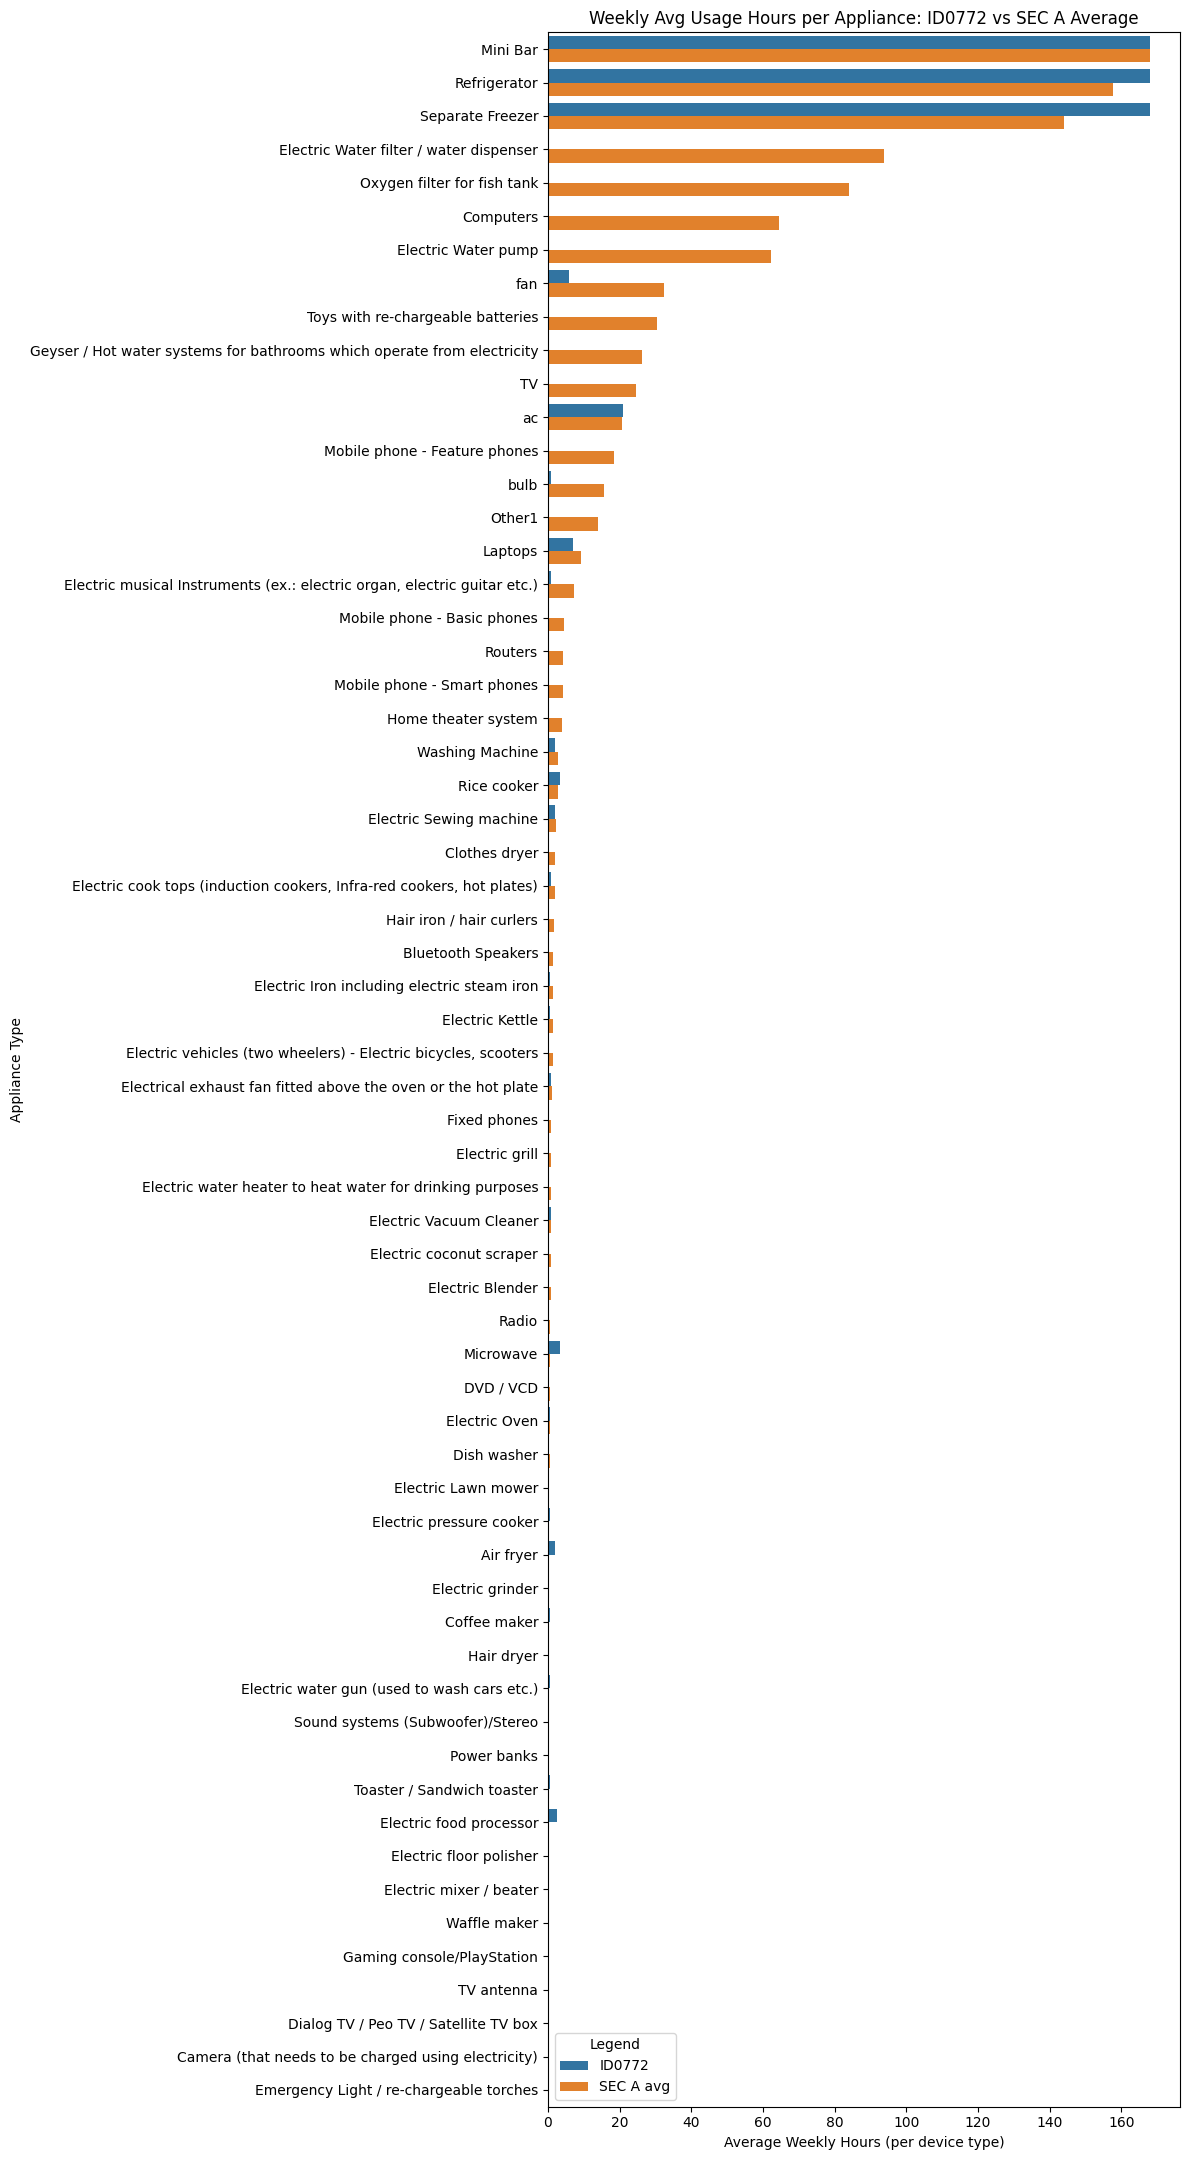

,appliance,household_hours,class_avg_hours
52,Mini Bar,168.000000,168.000000
64,Refrigerator,168.000000,157.697183
69,Separate Freezer,168.000000,144.000000
21,Electric Water filter / water dispenser,NaN,93.743704
59,Oxygen filter for fish tank,NaN,84.000000
6,Computers,NaN,64.515789
22,Electric Water pump,NaN,62.266667
77,fan,5.843750,32.445059
74,Toys with re-chargeable batteries,NaN,30.333333
44,Geyser / Hot water systems for bathrooms which...,NaN,26.214286


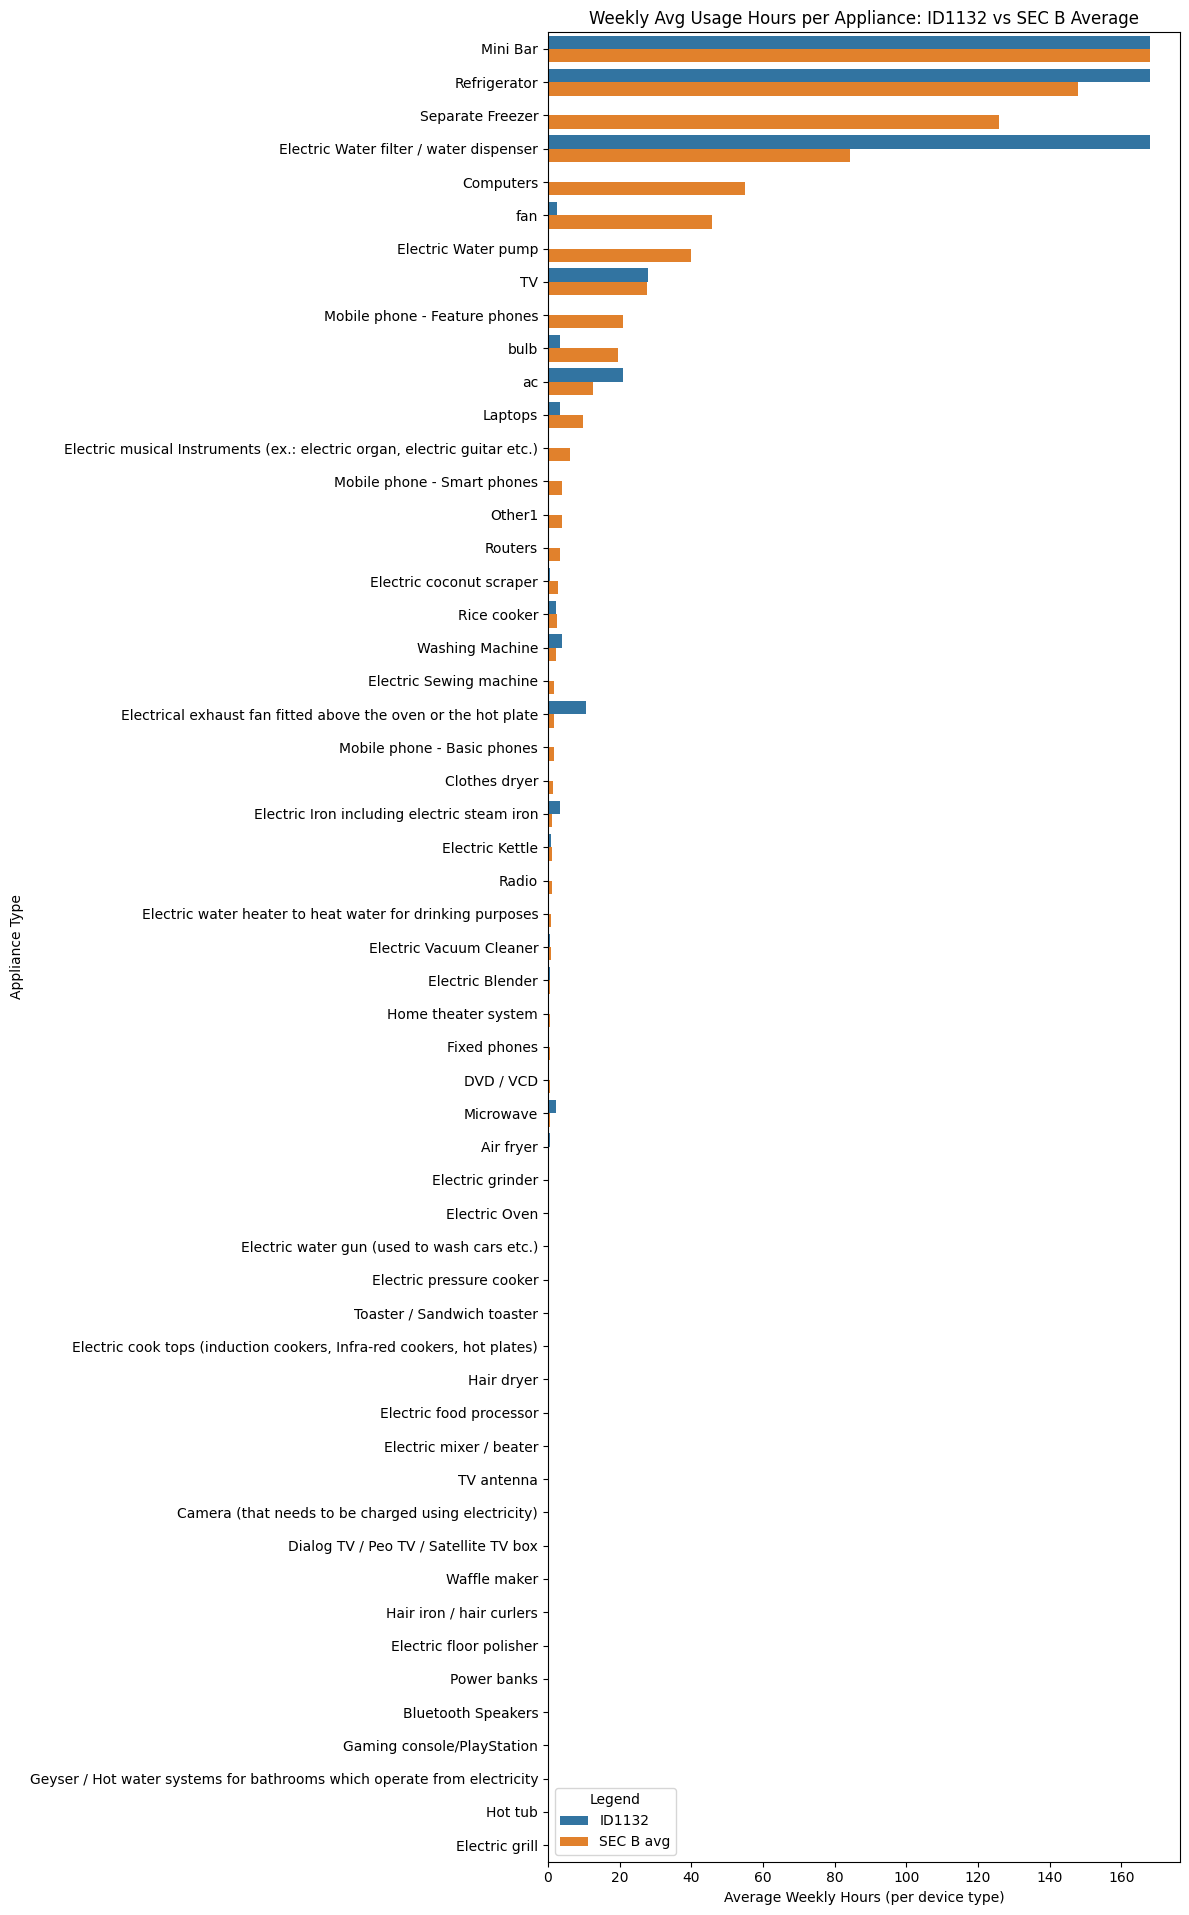

,appliance,household_hours,class_avg_hours
52,Mini Bar,168.000000,168.000000
64,Refrigerator,168.000000,147.922717
69,Separate Freezer,NaN,126.000000
21,Electric Water filter / water dispenser,168.000000,84.375000
6,Computers,NaN,55.111111
77,fan,2.625000,45.754882
22,Electric Water pump,NaN,39.800000
71,TV,28.000000,27.784156
54,Mobile phone - Feature phones,NaN,21.000000
79,bulb,3.313448,19.467685


In [14]:
# Compare two additional households (one from each remaining SEC_AGG class) vs their class averages
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
def plot_household_vs_class(hh_id, df):
    if hh_id not in df.index:
        print(f'{hh_id} not found. Skipping.')
        return
    hours_cols = [c for c in df.columns if c.startswith('hours__')]
    if not hours_cols:
        print('No hours__ columns available.')
        return
    hh_class = df.loc[hh_id, 'SEC_AGG'] if 'SEC_AGG' in df.columns else None
    if hh_class is None:
        print('SEC_AGG column missing.')
        return
    hh_row = df.loc[hh_id, hours_cols]
    class_means = df.loc[df['SEC_AGG']==hh_class, hours_cols].mean(numeric_only=True)
    comp_df = pd.DataFrame({'appliance':[c.replace('hours__','') for c in hours_cols], 'household_hours':hh_row.values.astype(float), 'class_avg_hours':class_means.values.astype(float)})
    comp_df = comp_df.dropna(how='all', subset=['household_hours','class_avg_hours'])
    if comp_df.empty:
        print(f'No usable hours data for {hh_id}.')
        return
    comp_df = comp_df.sort_values('class_avg_hours', ascending=False)
    plot_df = comp_df.melt(id_vars='appliance', value_vars=['household_hours','class_avg_hours'], var_name='type', value_name='hours')
    plot_df['type'] = plot_df['type'].map({'household_hours': hh_id, 'class_avg_hours': f'{hh_class} avg'})
    plt.figure(figsize=(12, max(4, 0.35*len(comp_df))))
    sns.barplot(data=plot_df, y='appliance', x='hours', hue='type', orient='h')
    plt.title(f'Weekly Avg Usage Hours per Appliance: {hh_id} vs {hh_class} Average')
    plt.xlabel('Average Weekly Hours (per device type)')
    plt.ylabel('Appliance Type')
    plt.legend(title='Legend')
    plt.tight_layout()
    plt.show()
    display(comp_df.head(30))
# Ensure merged_app exists
if 'merged_app' not in globals():
    raise RuntimeError('merged_app not found. Run earlier cells first.')
if 'SEC_AGG' not in merged_app.columns:
    raise RuntimeError('SEC_AGG column missing in merged_app.')
# Determine class of ID0456 (case-insensitive)
id0456_match = {str(i).lower(): i for i in merged_app.index}.get('id0456')
base_class = merged_app.loc[id0456_match, 'SEC_AGG'] if id0456_match in merged_app.index else None
remaining_classes = [c for c in sorted(merged_app['SEC_AGG'].unique()) if c != base_class]
selected_households = []
hours_cols_all = [c for c in merged_app.columns if c.startswith('hours__')]
for cls in remaining_classes:
    sub = merged_app[merged_app['SEC_AGG']==cls].copy()
    if sub.empty: continue
    # Score households: prioritize most non-missing hours, then highest total hours
    non_missing = sub[hours_cols_all].notna().sum(axis=1)
    total_hours = sub[hours_cols_all].fillna(0).sum(axis=1)
    best_id = (non_missing.rank(method='first', ascending=False) + (total_hours.rank(method='first', ascending=False)/10000)).sort_values().index[0]
    selected_households.append(best_id)
print('Selected comparison households (excluding base class):', selected_households)
for hh in selected_households:
    plot_household_vs_class(hh, merged_app)

## 5. Compare Average Consumption: Suspected Inefficient vs Normal Households by SEC Class

Compare the average electricity consumption between:
- **Suspected Inefficient Households**: Anomalous consumption (autoencoder) + Similar appliance usage patterns (std method)
- **Normal Households**: Non-anomalous consumption with different appliance usage patterns

Analysis performed per socio-economic class (SEC A, SEC B, SEC C).

In [9]:
# --- Load the suspected inefficient households ---
# These are households that are anomalous (autoencoder) AND have similar appliance usage (std method)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

suspected_file = 'anomalous_households_similar_appliance_usage_std.csv'

try:
    suspected_df = pd.read_csv(suspected_file)
    print(f'Loaded {len(suspected_df)} suspected inefficient households')
    suspected_households = set(suspected_df['household_ID'].astype(str))
except FileNotFoundError:
    print(f'File {suspected_file} not found. Using similar_df from previous analysis.')
    if 'similar_df' in globals():
        suspected_households = set(similar_df['household_ID'].astype(str))
        suspected_df = similar_df.copy()
    else:
        print('No suspected inefficient households data available. Using empty set.')
        suspected_households = set()

# --- Load all anomalous households ---
all_anomalous_file = 'anomalous_households_autoencoder_per_capita_all_classes.csv'
try:
    all_anomalous_df = pd.read_csv(all_anomalous_file)
    all_anomalous_households = set(all_anomalous_df['household_ID'].astype(str))
    print(f'Loaded {len(all_anomalous_households)} total anomalous households')
except FileNotFoundError:
    # Fallback: combine per-class anomalous households
    if 'per_class_anomalies' in globals():
        all_anomalous_households = set()
        for sec_class, hh_list in per_class_anomalies.items():
            all_anomalous_households.update([str(h) for h in hh_list])
        print(f'Using {len(all_anomalous_households)} anomalous households from memory')
    else:
        print('No anomalous households data available. Using empty set.')
        all_anomalous_households = set()

Loaded 50 suspected inefficient households
Loaded 288 total anomalous households


In [10]:
# --- Create SEC_AGG column if missing ---
# Check if SEC_AGG column exists in house_info
print(f'Columns in house_info: {house_info.columns.tolist()}')

if 'SEC_AGG' not in house_info.columns:
    print('SEC_AGG column not found. Creating it now...')
    
    # Define SEC aggregation mapping
    SEC_AGG_MAP = { 'SEC A': 'SEC A', 'SEC B': 'SEC A', 'SEC C': 'SEC B', 'SEC D': 'SEC C', 'SEC E': 'SEC C' }
    
    # Apply SEC aggregation map (case-insensitive safe)
    house_info['socio_economic_class'] = house_info['socio_economic_class'].astype(str).str.strip()
    house_info['SEC_AGG'] = house_info['socio_economic_class'].map(lambda x: SEC_AGG_MAP.get(x, np.nan))
    
    # Remove any households with unmapped SEC values
    before_count = len(house_info)
    house_info = house_info.dropna(subset=['SEC_AGG'])
    after_count = len(house_info)
    
    print(f'SEC_AGG column created successfully!')
    print(f'Households before SEC mapping: {before_count}')
    print(f'Households after SEC mapping: {after_count}')
    print(f'SEC_AGG distribution:')
    print(house_info['SEC_AGG'].value_counts())
else:
    print('SEC_AGG column already exists.')

# --- Classify households ---
# Convert column names to strings for consistent comparison
per_capita_households = set([str(h) for h in per_capita_df.columns])

house_info_str = house_info.copy()
house_info_str[hh_info_id_col] = house_info_str[hh_info_id_col].astype(str)

household_classification = []

for idx, row in house_info_str.iterrows():
    hh_id = str(row[hh_info_id_col])
    sec_class = row['SEC_AGG']
    
    # Only include households present in consumption data
    if hh_id not in per_capita_households:
        continue
    
    if hh_id in suspected_households:
        category = 'Suspected Inefficient'
    elif hh_id in all_anomalous_households:
        category = 'Other Anomalous'
    else:
        category = 'Normal'
    
    household_classification.append({
        'household_ID': hh_id,
        'SEC_AGG': sec_class,
        'category': category
    })

classification_df = pd.DataFrame(household_classification)
print(f'\nHousehold classification summary:')
print(classification_df.groupby(['SEC_AGG', 'category']).size().unstack(fill_value=0))

Columns in house_info: ['household_ID', 'no_of_household_members', 'socio_economic_class', 'SEC_AGG']
SEC_AGG column already exists.

Household classification summary:
category  Normal  Other Anomalous  Suspected Inefficient
SEC_AGG                                                 
SEC A        544              116                     21
SEC B        391               80                     18
SEC C        214               43                     11


Selected comparison households (excluding base class): ['ID0772', 'ID1132']


Selected comparison households (excluding base class): ['ID0772', 'ID1132']


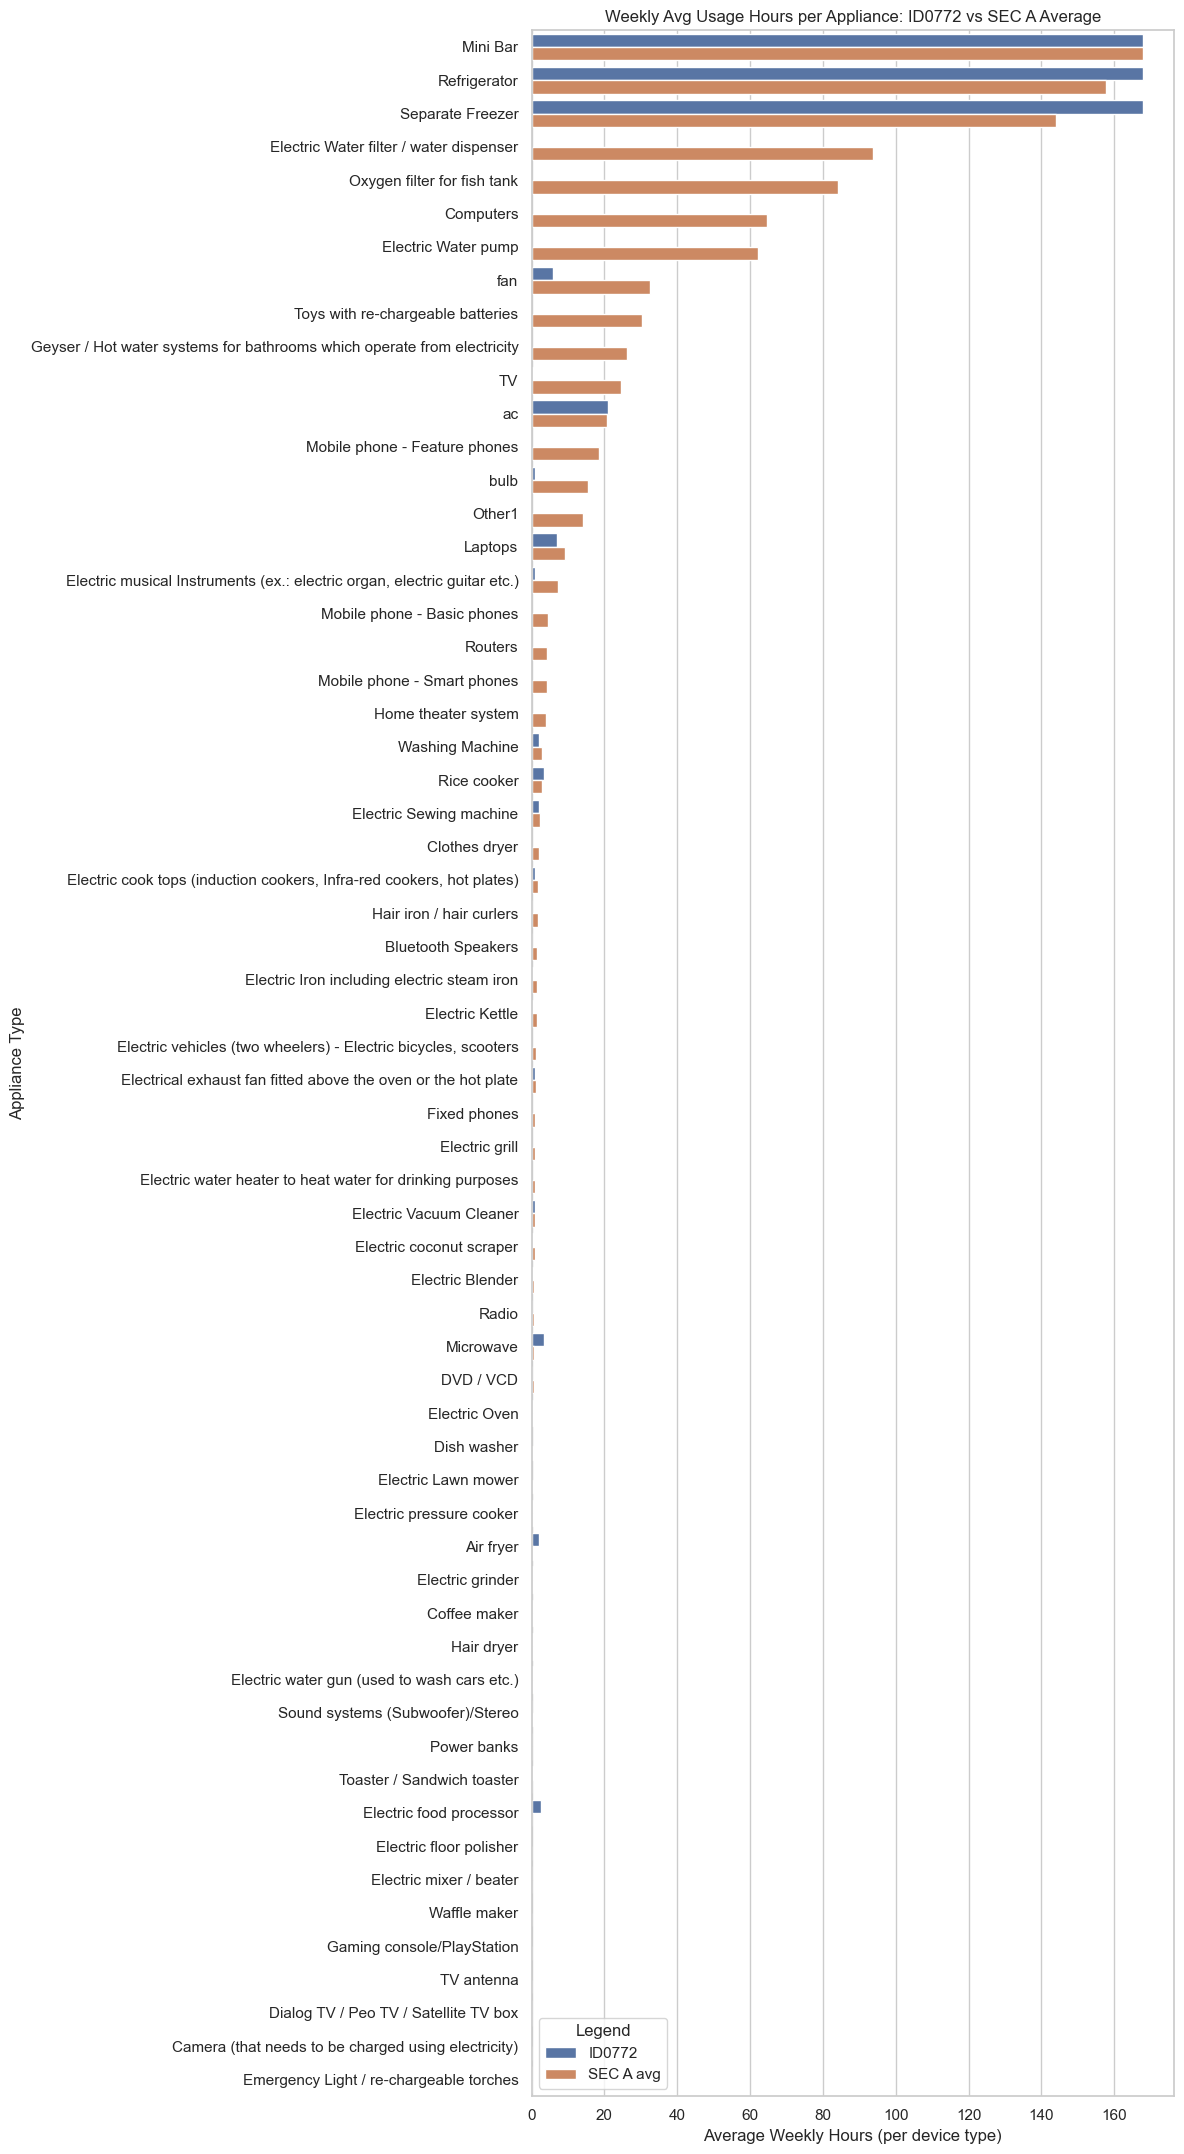

,appliance,household_hours,class_avg_hours
52,Mini Bar,168.000000,168.000000
64,Refrigerator,168.000000,157.697183
69,Separate Freezer,168.000000,144.000000
21,Electric Water filter / water dispenser,NaN,93.743704
59,Oxygen filter for fish tank,NaN,84.000000
6,Computers,NaN,64.515789
22,Electric Water pump,NaN,62.266667
77,fan,5.843750,32.445059
74,Toys with re-chargeable batteries,NaN,30.333333
44,Geyser / Hot water systems for bathrooms which...,NaN,26.214286


Selected comparison households (excluding base class): ['ID0772', 'ID1132']


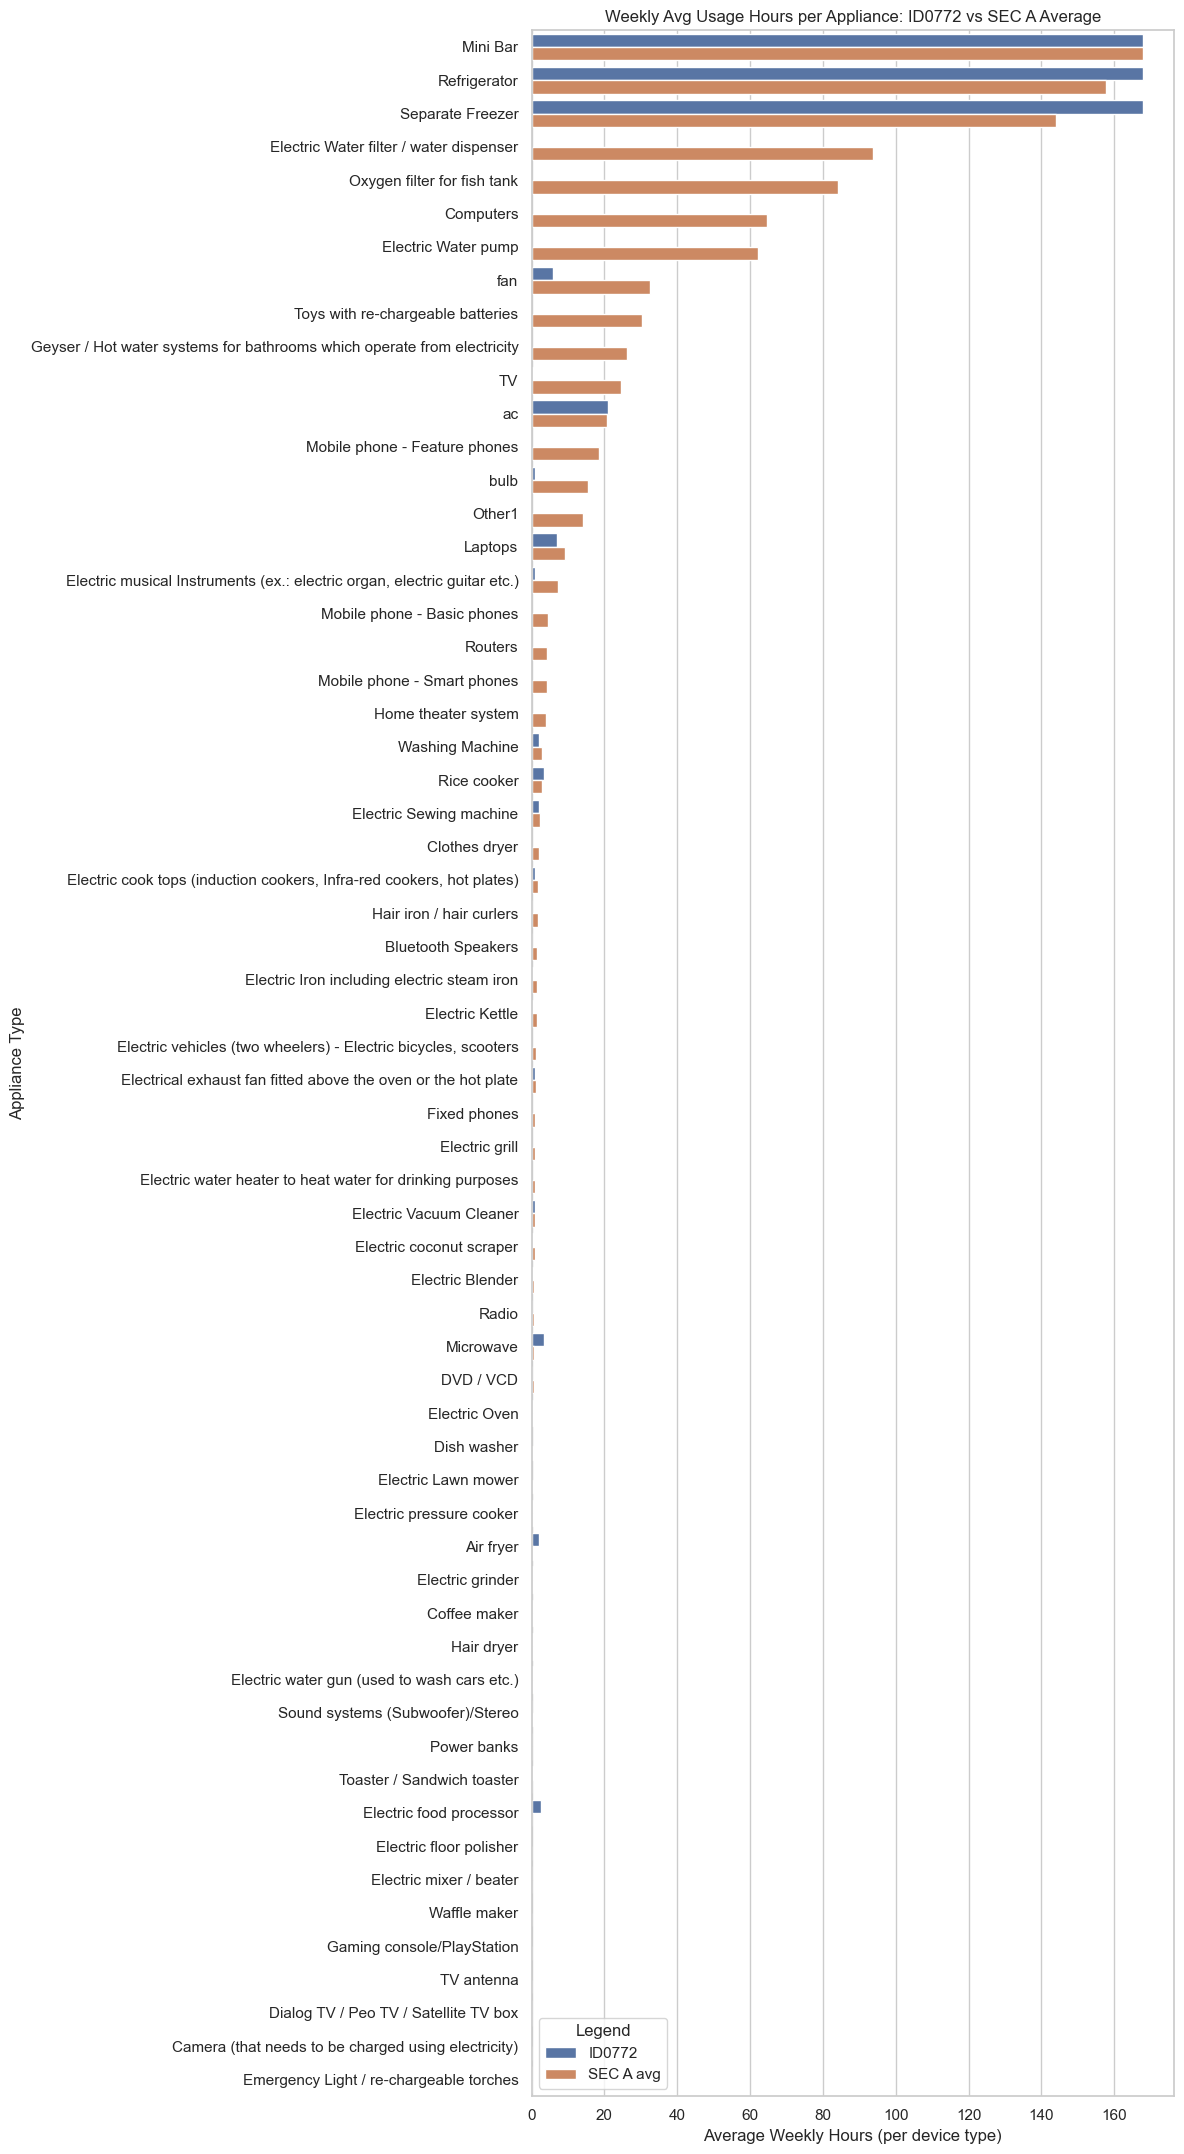

,appliance,household_hours,class_avg_hours
52,Mini Bar,168.000000,168.000000
64,Refrigerator,168.000000,157.697183
69,Separate Freezer,168.000000,144.000000
21,Electric Water filter / water dispenser,NaN,93.743704
59,Oxygen filter for fish tank,NaN,84.000000
6,Computers,NaN,64.515789
22,Electric Water pump,NaN,62.266667
77,fan,5.843750,32.445059
74,Toys with re-chargeable batteries,NaN,30.333333
44,Geyser / Hot water systems for bathrooms which...,NaN,26.214286


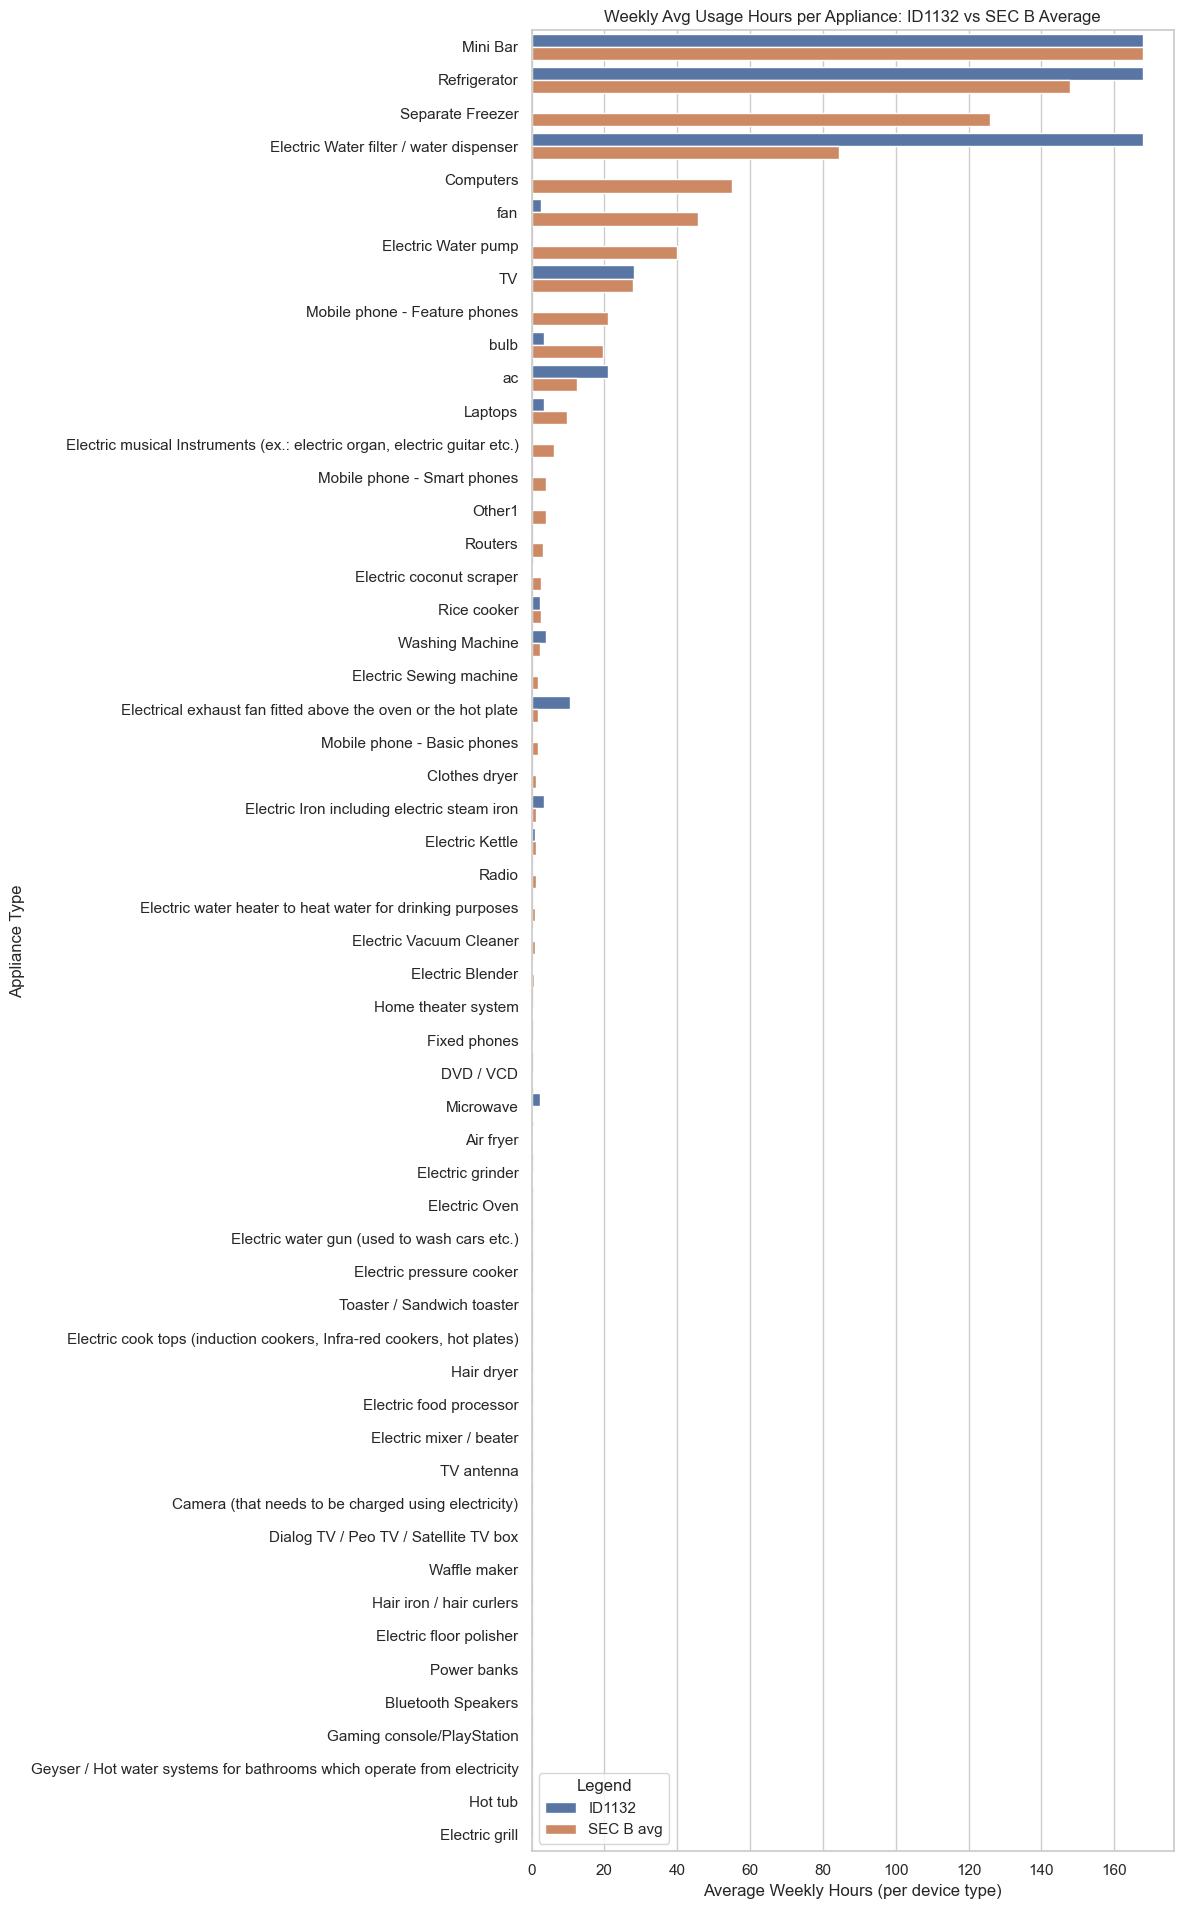

,appliance,household_hours,class_avg_hours
52,Mini Bar,168.000000,168.000000
64,Refrigerator,168.000000,147.922717
69,Separate Freezer,NaN,126.000000
21,Electric Water filter / water dispenser,168.000000,84.375000
6,Computers,NaN,55.111111
77,fan,2.625000,45.754882
22,Electric Water pump,NaN,39.800000
71,TV,28.000000,27.784156
54,Mobile phone - Feature phones,NaN,21.000000
79,bulb,3.313448,19.467685


In [120]:
# --- Compute average consumption per household ---
# Calculate mean consumption over all time periods for each household
household_avg_consumption = per_capita_df.mean(axis=0).to_frame('avg_consumption_per_capita')
household_avg_consumption['household_ID'] = household_avg_consumption.index.astype(str)
household_avg_consumption = household_avg_consumption.reset_index(drop=True)

# --- Merge with classification ---
consumption_analysis = pd.merge(
    classification_df,
    household_avg_consumption,
    on='household_ID',
    how='inner'
)

# Remove any households with missing consumption data
consumption_analysis = consumption_analysis.dropna(subset=['avg_consumption_per_capita'])

print(f'Total households in consumption analysis: {len(consumption_analysis)}')
print(f'\nFinal household counts by category:')
print(consumption_analysis.groupby(['SEC_AGG', 'category']).size().unstack(fill_value=0))

In [15]:
# Find anomalous households with similar appliance usage behavior to normal households
import numpy as np
import pandas as pd

# Get all hours__* columns for appliance usage
hours_cols = [col for col in merged_app.columns if col.startswith('hours__')]

# Function to calculate variance scores for a household vs normal averages
def calculate_appliance_variances(household_data, normal_means, hours_cols):
    variances = []
    for col in hours_cols:
        # Only consider appliances the household actually has (non-NaN values)
        if pd.notna(household_data[col]) and pd.notna(normal_means[col]):
            # Calculate normalized absolute difference
            diff = abs(household_data[col] - normal_means[col])
            # Normalize by the mean to get relative variance
            if normal_means[col] > 0:
                variance = diff / normal_means[col]
                variances.append(variance)
    return variances if variances else [np.inf]  # Return inf if no valid comparisons

# Set threshold for considering variance as 'small'
VARIANCE_THRESHOLD = 1  # 30% deviation threshold

similar_behavior_households = []

# Process each SEC class
for sec in ['SEC A', 'SEC B', 'SEC C']:
    # Get normal households for this SEC
    normal_mask = (merged_app['SEC_AGG'] == sec) & (~merged_app['anomalous'])
    normal_means = merged_app[normal_mask][hours_cols].mean()

    # Get anomalous households for this SEC
    anomalous_mask = (merged_app['SEC_AGG'] == sec) & (merged_app['anomalous'])
    anomalous_households = merged_app[anomalous_mask]

    # Check each anomalous household
    for idx, household in anomalous_households.iterrows():
        variances = calculate_appliance_variances(household, normal_means, hours_cols)
        # If ALL appliance variances are below threshold, consider it similar
        if all(v <= VARIANCE_THRESHOLD for v in variances) and len(variances) > 0:
            similar_behavior_households.append({
                'household_ID': idx,
                'SEC_AGG': sec,
                'num_appliances_compared': len(variances),
                'max_variance': max(variances)
            })

# Create DataFrame of similar behavior households
similar_df = pd.DataFrame(similar_behavior_households)

# Save results
if not similar_df.empty:
    similar_df.to_csv('anomalous_households_similar_appliance_usage.csv', index=False)
    # Show summary by SEC
    print('\nAnomalous households with similar appliance usage behavior to normal households:')
    print(similar_df.groupby('SEC_AGG')['household_ID'].count())
    print('\nDetailed results:')
    display(similar_df)

    # Additional analysis - show appliance usage comparison for first few households
    print('\nDetailed appliance usage comparison for first household:')
    if len(similar_df) > 0:
        example_hh = similar_df['household_ID'].iloc[0]
        sec = similar_df['SEC_AGG'].iloc[0]
        
        # Get normal averages for this SEC
        normal_mask = (merged_app['SEC_AGG'] == sec) & (~merged_app['anomalous'])
        normal_means = merged_app[normal_mask][hours_cols].mean()
        
        # Get household data
        hh_data = merged_app.loc[example_hh][hours_cols]
        
        # Create comparison DataFrame
        comparison = pd.DataFrame({
            'appliance': [col.replace('hours__','') for col in hours_cols],
            'household_hours': hh_data.values,
            'normal_average': normal_means.values
        })
        # Only show appliances present in the household
        comparison = comparison.dropna(subset=['household_hours'])
        comparison['variance'] = abs(comparison['household_hours'] - comparison['normal_average']) / comparison['normal_average']
        comparison = comparison.sort_values('variance')
        display(comparison)
else:
    print('No anomalous households found with similar appliance usage behavior to normal households')


Anomalous households with similar appliance usage behavior to normal households:
SEC_AGG
SEC A    44
SEC B    46
SEC C    27
Name: household_ID, dtype: int64

Detailed results:


,household_ID,SEC_AGG,num_appliances_compared,max_variance
0,ID0043,SEC A,19,1.000000
1,ID0113,SEC A,15,1.000000
2,ID0290,SEC A,8,1.000000
3,ID0449,SEC A,9,1.000000
4,ID0502,SEC A,8,1.000000
...,...,...,...,...
112,ID2951,SEC C,6,0.730094
113,ID2953,SEC C,5,0.861034
114,ID2964,SEC C,3,0.662229
115,ID3005,SEC C,5,1.000000



Detailed appliance usage comparison for first household:


,appliance,household_hours,normal_average,variance
28,Electric grinder,0.3,0.319279,0.060384
64,Refrigerator,168.0,156.836275,0.071181
6,Computers,70.0,64.014925,0.093495
71,TV,21.0,24.422181,0.140126
50,Laptops,10.5,9.160307,0.14625
16,Electric Kettle,1.0,1.246440,0.197715
55,Mobile phone - Smart phones,3.5,4.393923,0.203445
20,Electric Vacuum Cleaner,1.0,0.792897,0.261198
65,Rice cooker,2.0,2.801351,0.286059
15,Electric Iron including electric steam iron,1.0,1.412005,0.291787


In [16]:
# Find anomalous households with similar appliance usage behavior (only selected appliances)
import numpy as np
import pandas as pd

# Appliances of interest
target_appliances = [
    "TV",
    "ac",
    "Washing Machine",
    "fan",
    "Geyser / Hot water systems for bathrooms which operate from electricity",
    "Electric Water pump"
]

# Map to hours__* column names
target_cols = [f"hours__{a}" for a in target_appliances]

# Keep only the subset of appliances that exist in merged_app
hours_cols = [col for col in target_cols if col in merged_app.columns]

print("Appliances being considered:", [col.replace("hours__","") for col in hours_cols])

# Function to check if household usage is within k standard deviations of normals
def within_std_deviation(household_data, normal_means, normal_stds, hours_cols, k=1):
    checks = []
    for col in hours_cols:
        if pd.notna(household_data[col]) and pd.notna(normal_means[col]) and pd.notna(normal_stds[col]):
            diff = abs(household_data[col] - normal_means[col])
            checks.append(diff <= k * normal_stds[col])
    return checks if checks else [False]  # if no valid appliances, return False

# Configurable parameter: how many standard deviations to allow
K_STD = 1   # try 1, 1.5, or 2

similar_behavior_households = []

# Process each SEC class
for sec in ['SEC A', 'SEC B', 'SEC C']:
    # Get normal households for this SEC
    normal_mask = (merged_app['SEC_AGG'] == sec) & (~merged_app['anomalous'])
    normal_subset = merged_app[normal_mask][hours_cols]
    
    # Skip SEC if no target appliances exist in this group
    available_cols = [c for c in hours_cols if normal_subset[c].notna().any()]
    if not available_cols:
        print(f"Skipping {sec}: none of the target appliances available.")
        continue

    normal_means = normal_subset[available_cols].mean()
    normal_stds = normal_subset[available_cols].std()

    # Get anomalous households for this SEC
    anomalous_mask = (merged_app['SEC_AGG'] == sec) & (merged_app['anomalous'])
    anomalous_households = merged_app[anomalous_mask]

    # Check each anomalous household
    for idx, household in anomalous_households.iterrows():
        checks = within_std_deviation(household, normal_means, normal_stds, available_cols, k=K_STD)
        # If ALL appliances are within k std devs → similar
        if all(checks):
            similar_behavior_households.append({
                'household_ID': idx,
                'SEC_AGG': sec,
                'num_appliances_compared': len(checks),
                'appliances_compared': [c.replace("hours__","") for c in available_cols],
                'k_std_used': K_STD
            })

# Create DataFrame of similar behavior households
similar_df = pd.DataFrame(similar_behavior_households)

# Save results
if not similar_df.empty:
    similar_df.to_csv('anomalous_households_similar_selected_appliances.csv', index=False)
    # Show summary by SEC
    print('\nAnomalous households with similar appliance usage behavior (selected appliances only):')
    print(similar_df.groupby('SEC_AGG')['household_ID'].count())
    print('\nDetailed results:')
    display(similar_df)

    # Additional analysis - show appliance usage comparison for first household
    print('\nDetailed appliance usage comparison for first household:')
    if len(similar_df) > 0:
        example_hh = similar_df['household_ID'].iloc[0]
        sec = similar_df['SEC_AGG'].iloc[0]
        
        # Get normal averages and stds for this SEC
        normal_mask = (merged_app['SEC_AGG'] == sec) & (~merged_app['anomalous'])
        normal_means = merged_app[normal_mask][hours_cols].mean()
        normal_stds = merged_app[normal_mask][hours_cols].std()
        
        # Get household data
        hh_data = merged_app.loc[example_hh][hours_cols]
        
        # Create comparison DataFrame
        comparison = pd.DataFrame({
            'appliance': [col.replace('hours__','') for col in hours_cols],
            'household_hours': hh_data.values,
            'normal_average': normal_means.values,
            'normal_std': normal_stds.values
        })
        # Only show appliances present in both normal group and household
        comparison = comparison.dropna(subset=['household_hours','normal_average','normal_std'])
        comparison['within_k_std'] = abs(comparison['household_hours'] - comparison['normal_average']) <= K_STD * comparison['normal_std']
        display(comparison)
else:
    print('No anomalous households found with similar appliance usage behavior (selected appliances only)')

Appliances being considered: ['TV', 'ac', 'Washing Machine', 'fan', 'Geyser / Hot water systems for bathrooms which operate from electricity', 'Electric Water pump']

Anomalous households with similar appliance usage behavior (selected appliances only):
SEC_AGG
SEC A    59
SEC B    48
SEC C    22
Name: household_ID, dtype: int64

Detailed results:


,household_ID,SEC_AGG,num_appliances_compared,appliances_compared,k_std_used
0,ID0113,SEC A,4,"[TV, ac, Washing Machine, fan, Geyser / Hot wa...",1
1,ID0135,SEC A,2,"[TV, ac, Washing Machine, fan, Geyser / Hot wa...",1
2,ID0183,SEC A,4,"[TV, ac, Washing Machine, fan, Geyser / Hot wa...",1
3,ID0250,SEC A,4,"[TV, ac, Washing Machine, fan, Geyser / Hot wa...",1
4,ID0417,SEC A,4,"[TV, ac, Washing Machine, fan, Geyser / Hot wa...",1
...,...,...,...,...,...
124,ID3005,SEC C,1,"[TV, ac, Washing Machine, fan]",1
125,ID3225,SEC C,1,"[TV, ac, Washing Machine, fan]",1
126,ID3359,SEC C,2,"[TV, ac, Washing Machine, fan]",1
127,ID3427,SEC C,1,"[TV, ac, Washing Machine, fan]",1



Detailed appliance usage comparison for first household:


,appliance,household_hours,normal_average,normal_std,within_k_std
0,TV,7.0,24.422181,19.327322,True
1,ac,0.0,20.320844,23.805531,True
2,Washing Machine,1.0,2.744667,2.990535,True
3,fan,17.5,32.307968,24.005863,True


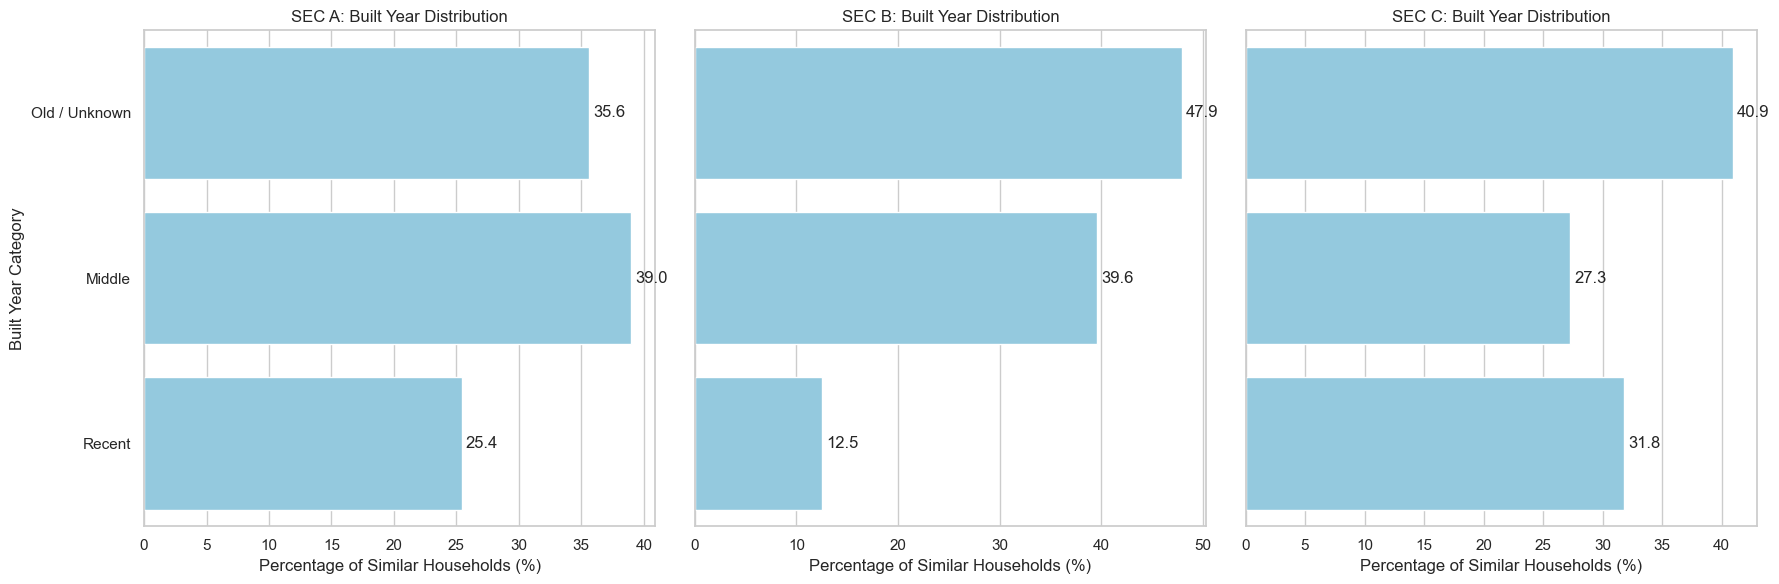

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load household info ---
info_path = Path('wave_1/w1_household_information_and_history.csv')
if not info_path.exists():
    raise FileNotFoundError('Household info file missing.')

house_info = pd.read_csv(info_path)

# Merge with similar households
similar_info = pd.merge(
    similar_df,
    house_info[['household_ID', 'built_year_of_the_house']],
    on='household_ID',
    how='left'
)

# --- Recode built_year_of_the_house ---
def recategorize_year(x):
    if pd.isna(x):
        return 'Old / Unknown'
    x = str(x).strip()
    if x.lower() == "don't know" or 'Before 1980' in x or '1980-1989' in x:
        return 'Old / Unknown'
    elif '1990-1999' in x or '2000-2009' in x:
        return 'Middle'
    elif '2010' in x or '2010-2019' in x or '2020' in x:
        return 'Recent'
    else:
        return 'Old / Unknown'

similar_info['built_year_cat'] = similar_info['built_year_of_the_house'].apply(recategorize_year)

# Fix category order
cat_order = ['Old / Unknown', 'Middle', 'Recent']
similar_info['built_year_cat'] = pd.Categorical(similar_info['built_year_cat'], categories=cat_order, ordered=True)

# Count per SEC + new category
counts = (
    similar_info
    .groupby(['SEC_AGG', 'built_year_cat'])
    .size()
    .reset_index(name='count')
)

# Compute percentages within each SEC
counts['percentage'] = (
    counts.groupby('SEC_AGG')['count']
    .transform(lambda x: 100 * x / x.sum())
)

# --- Plot horizontal barplots side by side ---
secs = sorted(counts['SEC_AGG'].unique())
n_secs = len(secs)

fig, axes = plt.subplots(1, n_secs, figsize=(6*n_secs, 6), sharey=True)

if n_secs == 1:
    axes = [axes]  # ensure iterable

for ax, sec in zip(axes, secs):
    subset = counts[counts['SEC_AGG'] == sec]
    sns.barplot(
        data=subset,
        x='percentage',
        y='built_year_cat',
        order=cat_order,  # enforce fixed order
        color='skyblue',
        ax=ax
    )
    ax.set_title(f"{sec}: Built Year Distribution")
    ax.set_xlabel("Percentage of Similar Households (%)")
    ax.set_ylabel("Built Year Category")
    
    # Add value labels at end of bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f", label_type="edge", padding=3)

plt.tight_layout()
plt.show()

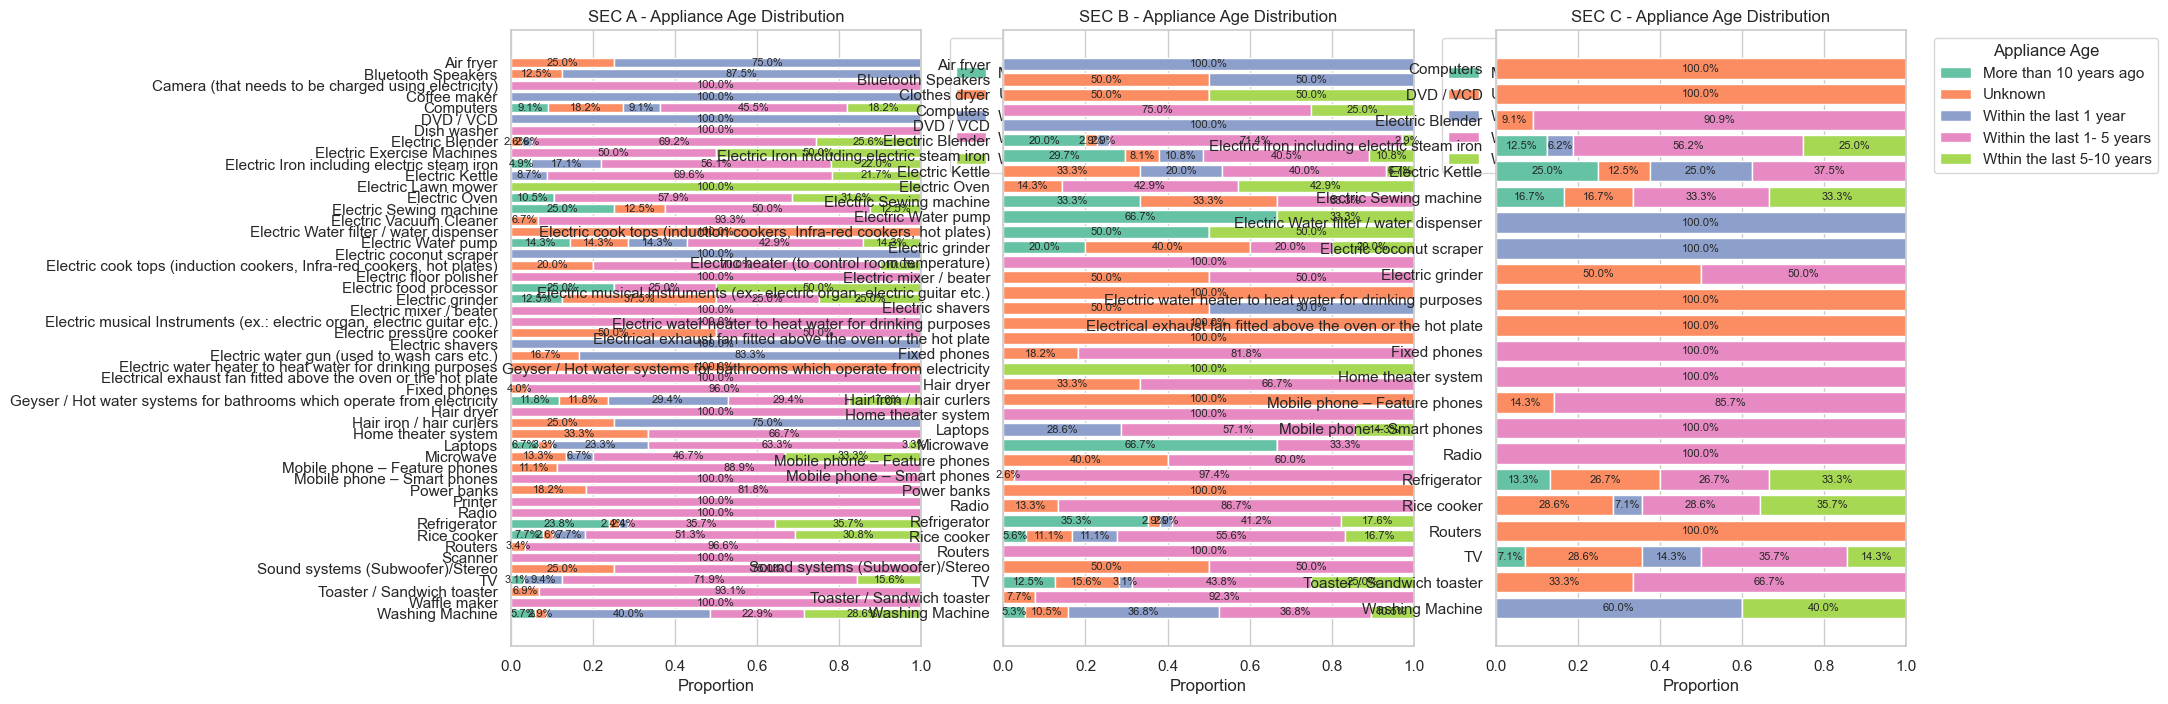

Saved -> appliance_age_distribution_similar_anomalous_households_by_sec.csv


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- Load appliance specs ---
AGE_FILE = Path('/Users/ediritillekegeranushinimthara/Library/CloudStorage/OneDrive-LIRNEasia/Ranushi/Lacuna/vscode/wave_1/household_appliance_specifications_202509020921.csv')
spec_df = pd.read_csv(AGE_FILE, low_memory=False)
spec_df.columns = [c.strip().lower().replace(' ', '_') for c in spec_df.columns]

# Identify columns
hh_col_age = next(c for c in spec_df.columns if 'household' in c and 'id' in c)
appliance_col = next(c for c in spec_df.columns if 'appliance' in c and ('name' in c or c.endswith('appliance')))

# Collapse purchase_time columns into one
age_cols = sorted([c for c in spec_df.columns if c.startswith('purchased_time')],
                  key=lambda x: int(''.join(filter(str.isdigit, x)) or 0))

def pick_age(row):
    for c in age_cols:
        val = str(row[c]).strip()
        if pd.notna(row[c]) and val != '' and val.lower() not in ['nan']:
            return val
    return 'Unknown'

spec_df['appliance_age'] = spec_df.apply(pick_age, axis=1)
age_long = spec_df[[hh_col_age, appliance_col, 'appliance_age']].copy()

# --- Filter to households identified as similar anomalous usage ---
age_similar = age_long.merge(similar_df[['household_ID', 'SEC_AGG']], 
                             left_on=hh_col_age, right_on='household_ID', how='inner')

# --- Compute proportions per SEC class and appliance ---
dist = (
    age_similar.groupby(['SEC_AGG','appliance_name','appliance_age'])[appliance_col]
    .count()
    .rename('count')
    .reset_index()
)
dist['proportion'] = dist.groupby(['SEC_AGG','appliance_name'])['count'].transform(lambda s: s / s.sum())

# --- Plot horizontal stacked bars per SEC ---
sec_classes = sorted(dist['SEC_AGG'].unique())
n_sec = len(sec_classes)

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, n_sec, figsize=(6*n_sec, 8), sharey=False)
if n_sec == 1:
    axes = [axes]

for ax, sec in zip(axes, sec_classes):
    sec_data = dist[dist['SEC_AGG']==sec].copy()
    appliances = sec_data['appliance_name'].unique()
    y_positions = np.arange(len(appliances))
    bottom_vals = np.zeros(len(appliances))

    colors = sns.color_palette("Set2", dist['appliance_age'].nunique())

    for i, age_cat in enumerate(sorted(sec_data['appliance_age'].unique())):
        subset = sec_data[sec_data['appliance_age']==age_cat].set_index('appliance_name')
        vals = [subset['proportion'].get(appl,0) for appl in appliances]
        bars = ax.barh(y_positions, vals, left=bottom_vals, label=age_cat, color=colors[i])
        bottom_vals += vals

        # Add percentages
        for bar, val in zip(bars, vals):
            if val > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2,
                        f'{val*100:.1f}%', ha='center', va='center', fontsize=8)

    ax.set_yticks(y_positions)
    ax.set_yticklabels(appliances)
    ax.set_xlabel('Proportion')
    ax.set_title(f'{sec} - Appliance Age Distribution')
    ax.invert_yaxis()
    ax.legend(title='Appliance Age', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Optional: save table
dist.to_csv('appliance_age_distribution_similar_anomalous_households_by_sec.csv', index=False)
print('Saved -> appliance_age_distribution_similar_anomalous_households_by_sec.csv')

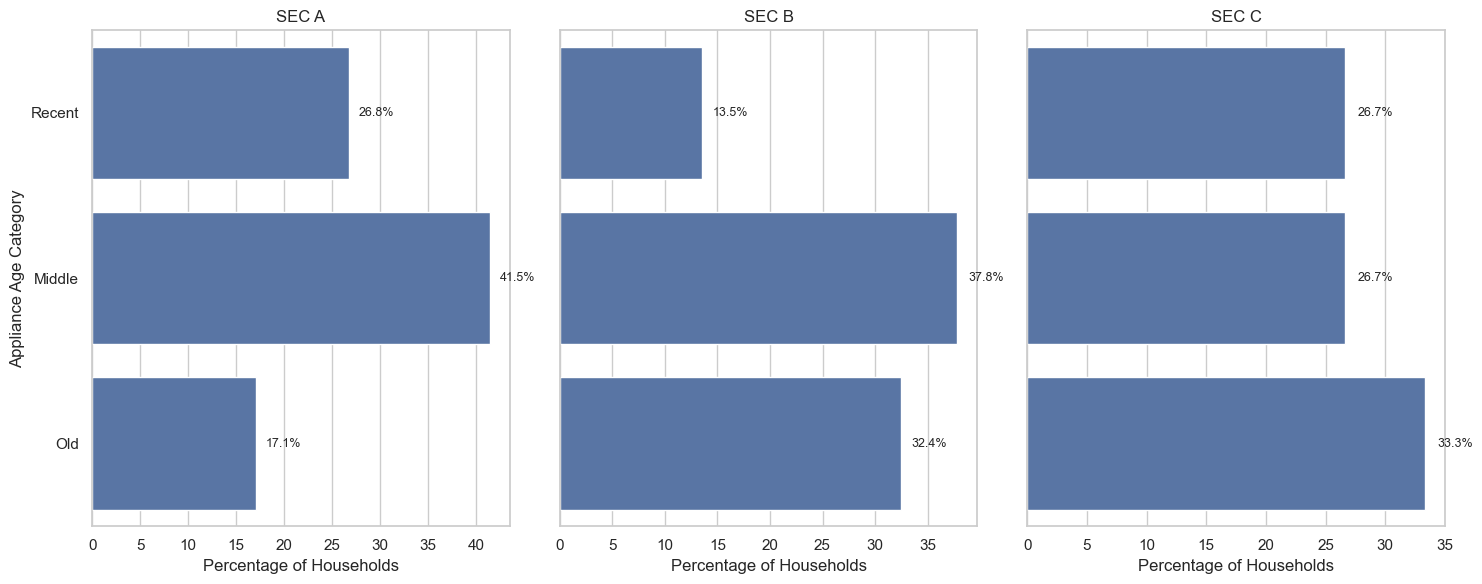

Saved -> household_mode_appliance_age_by_SEC_percent.csv


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Keep only target appliances ---
target_appliances = [
    "TV",
    "Air Conditioner",
    "Washing Machine",
    "Fan",
    "Geyser / Hot water systems for bathrooms which operate from electricity",
    "Electric Water pump"
]

age_subset = age_similar[age_similar[appliance_col].isin(target_appliances)].copy()

# --- Compute household-level mode of appliance age ---
household_mode_age = (
    age_subset.groupby([hh_col_age, 'SEC_AGG'])['appliance_age']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
    .reset_index()
    .rename(columns={'appliance_age':'mode_appliance_age'})
)

# --- Recode appliance age into broader categories ---
def recode_age(age):
    if age in ['More than 10 years ago', 'Unknown']:
        return 'Old'
    elif age in ['Within the last 1- 5 years', 'Within the last 5- 10 years']:
        return 'Middle'
    elif age == 'Within the last 1 year':
        return 'Recent'
    else:
        return age

household_mode_age['age_group'] = household_mode_age['mode_appliance_age'].apply(recode_age)

# --- Count households per SEC and recoded age group ---
household_age_count = (
    household_mode_age.groupby(['SEC_AGG','age_group'])[hh_col_age]
    .count()
    .rename('count')
    .reset_index()
)

# --- Convert counts to percentages within each SEC ---
household_age_count['percentage'] = household_age_count.groupby('SEC_AGG')['count'].transform(lambda x: 100 * x / x.sum())

# --- Plot percentages (horizontal bars) ---
classes = sorted(household_age_count['SEC_AGG'].unique())
fig, axes = plt.subplots(1, len(classes), figsize=(5*len(classes), 6), sharey=True)
if len(classes) == 1:
    axes = [axes]

age_order = ['Recent', 'Middle', 'Old']

for ax, sec in zip(axes, classes):
    sub = household_age_count[household_age_count['SEC_AGG']==sec].copy()
    sub['age_group'] = pd.Categorical(sub['age_group'], categories=age_order, ordered=True)
    sub = sub.sort_values('age_group')
    
    # Horizontal bars: swap x and y
    sns.barplot(data=sub, y='age_group', x='percentage', ax=ax, color='#4c72b0')
    ax.set_title(f'{sec}')
    ax.set_xlabel('Percentage of Households')
    ax.set_ylabel('Appliance Age Category')
    
    # Add percentage labels
    for p in ax.patches:
        w = p.get_width()
        if np.isnan(w) or w == 0:
            continue
        ax.text(w + 1, p.get_y() + p.get_height()/2, f'{w:.1f}%', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Optional: save table
household_age_count.to_csv('household_mode_appliance_age_by_SEC_percent.csv', index=False)
print('Saved -> household_mode_appliance_age_by_SEC_percent.csv')


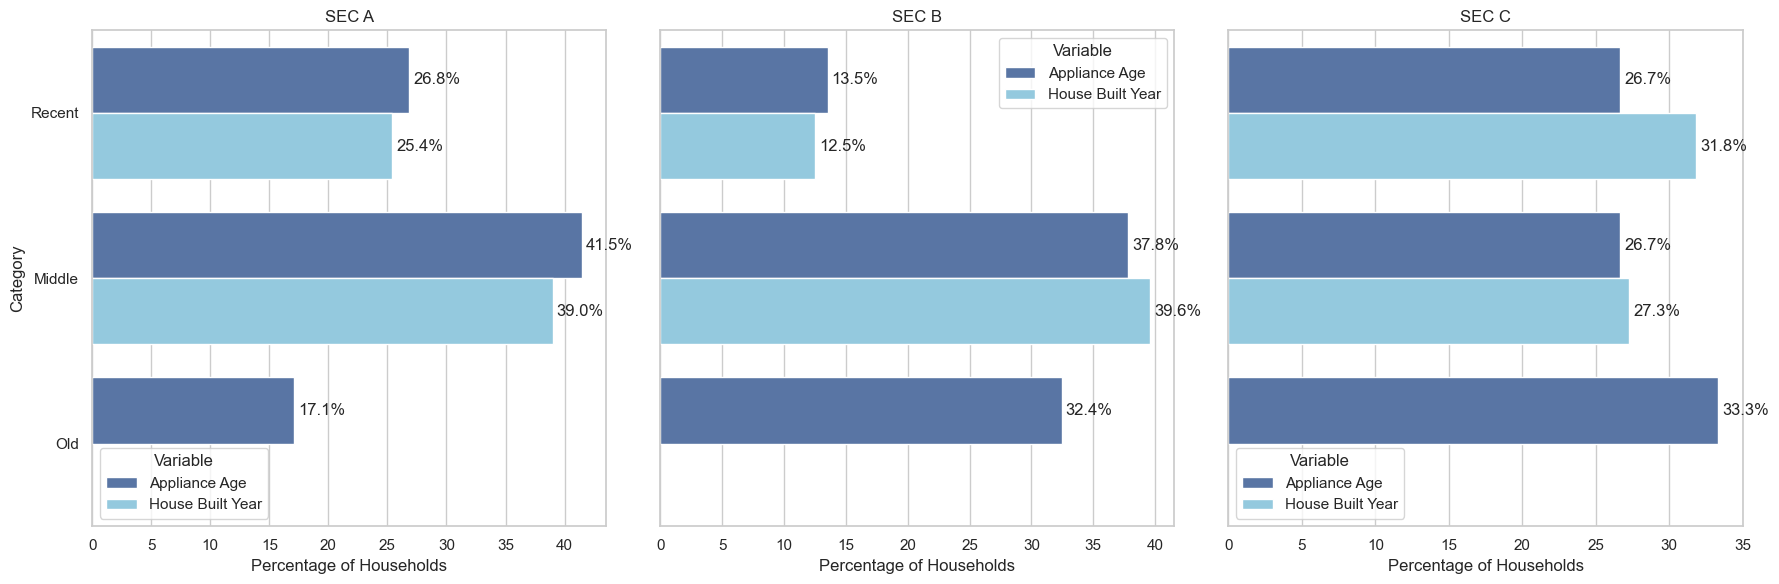

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Harmonize category order ---
cat_order = ['Recent', 'Middle', 'Old']

# --- Rename datasets for clarity ---
appliance_dist = household_age_count.copy()
appliance_dist['variable'] = 'Appliance Age'
appliance_dist = appliance_dist.rename(columns={'age_group': 'category'})

house_dist = counts.copy()
house_dist['variable'] = 'House Built Year'
house_dist = house_dist.rename(columns={'built_year_cat': 'category'})

# --- Combine both datasets ---
combined = pd.concat([
    appliance_dist[['SEC_AGG', 'category', 'percentage', 'variable']],
    house_dist[['SEC_AGG', 'category', 'percentage', 'variable']]
], ignore_index=True)

# Ensure consistent order
combined['category'] = pd.Categorical(combined['category'], categories=cat_order, ordered=True)

# --- Plot ---
secs = sorted(combined['SEC_AGG'].unique())
n_secs = len(secs)

fig, axes = plt.subplots(1, n_secs, figsize=(6*n_secs, 6), sharey=True)

if n_secs == 1:
    axes = [axes]

palette = {'Appliance Age': '#4c72b0', 'House Built Year': 'skyblue'}

for ax, sec in zip(axes, secs):
    subset = combined[combined['SEC_AGG'] == sec]
    
    # Remove duplicate rows for the same category+variable (prevents Seaborn error)
    subset = subset.drop_duplicates(subset=['category', 'variable'])
    
    sns.barplot(
        data=subset,
        x='percentage',
        y='category',
        hue='variable',
        palette=palette,
        ax=ax
    )
    
    ax.set_title(f"{sec}")
    ax.set_xlabel("Percentage of Households")
    ax.set_ylabel("Category")
    ax.legend(title="Variable")
    
    # Add value labels for each bar
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f%%", label_type="edge", padding=3)

plt.tight_layout()
plt.show()



In [63]:
similar_info.columns

Index(['household_ID', 'SEC_AGG', 'num_appliances_compared',
       'appliances_compared', 'k_std_used', 'built_year_of_the_house',
       'built_year_cat'],
      dtype='object')

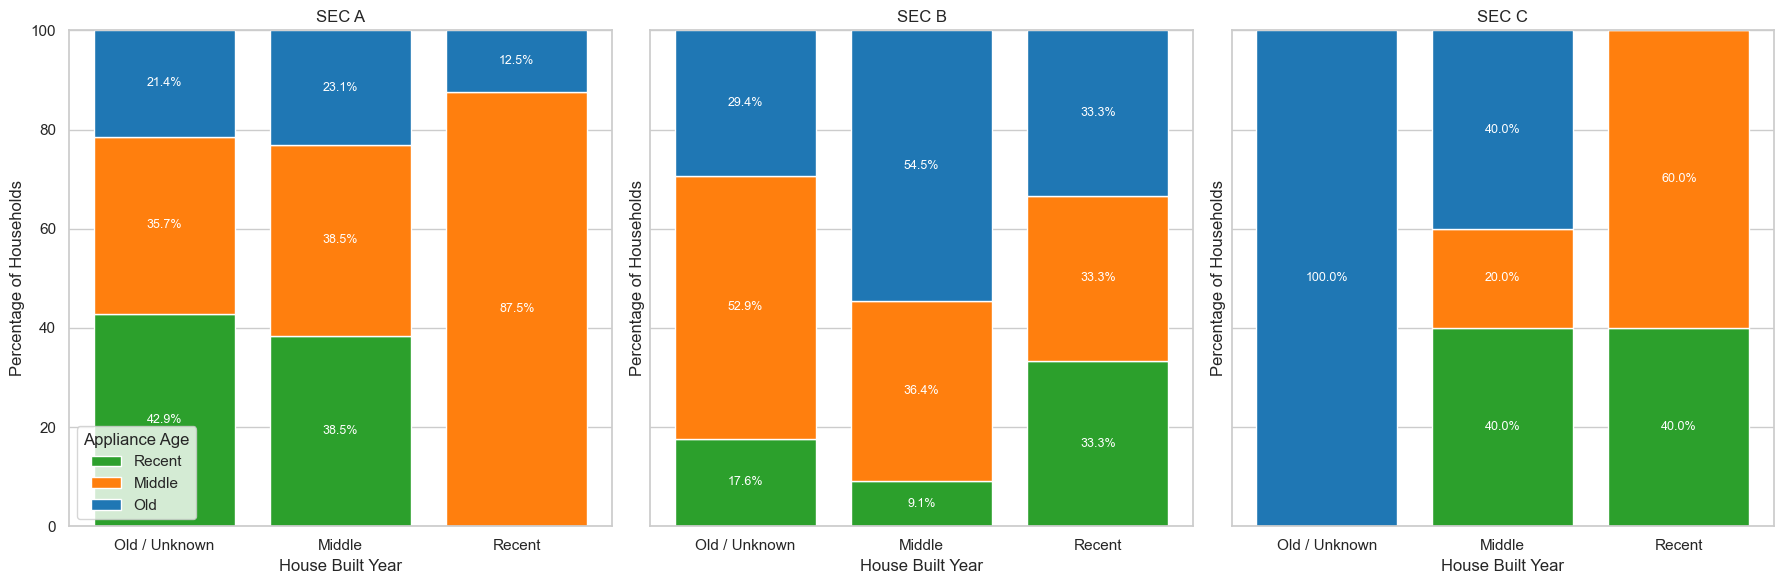

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Make column names consistent ---
household_mode_age = household_mode_age.rename(columns={'household_id':'household_ID'})

# --- Merge ---
merged = pd.merge(
    household_mode_age[['household_ID', 'SEC_AGG', 'age_group']],
    similar_info[['household_ID', 'SEC_AGG', 'built_year_cat']],
    on=['household_ID', 'SEC_AGG'],
    how='inner'
)

# --- Ensure category orders ---
appliance_order = ['Recent', 'Middle', 'Old']
built_order = ['Old / Unknown', 'Middle', 'Recent']

merged['age_group'] = pd.Categorical(merged['age_group'], categories=appliance_order, ordered=True)
merged['built_year_cat'] = pd.Categorical(merged['built_year_cat'], categories=built_order, ordered=True)

# --- Plot stacked bars per SEC ---
secs = merged['SEC_AGG'].unique()
colors = {'Recent':'#2ca02c', 'Middle':'#ff7f0e', 'Old':'#1f77b4'}

fig, axes = plt.subplots(1, len(secs), figsize=(6*len(secs),6), sharey=True)
if len(secs) == 1:
    axes = [axes]

for ax, sec in zip(axes, secs):
    sec_data = merged[merged['SEC_AGG']==sec]
    
    # Crosstab for this SEC (percentage within built year)
    cross_tab = pd.crosstab(
        index=sec_data['built_year_cat'],
        columns=sec_data['age_group']
    )
    cross_tab = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
    cross_tab = cross_tab[appliance_order]  # ensure column order
    cross_tab = cross_tab.reindex(built_order)  # ensure row order
    
    # Plot stacked bars
    bottom = pd.Series([0]*cross_tab.shape[0], index=cross_tab.index)
    for age in cross_tab.columns:
        ax.bar(cross_tab.index, cross_tab[age], bottom=bottom, color=colors[age], label=age)
        bottom += cross_tab[age]
    
    ax.set_title(f"{sec}")
    ax.set_xlabel("House Built Year")
    ax.set_ylabel("Percentage of Households")
    
    # Add labels
    for i, built_year in enumerate(cross_tab.index):
        cumulative = 0
        for age in cross_tab.columns:
            pct = cross_tab.loc[built_year, age]
            if pct > 0:
                ax.text(
                    i, cumulative + pct/2,
                    f"{pct:.1f}%", ha='center', va='center', color='white', fontsize=9
                )
                cumulative += pct

axes[0].legend(title="Appliance Age")
plt.tight_layout()
plt.show()


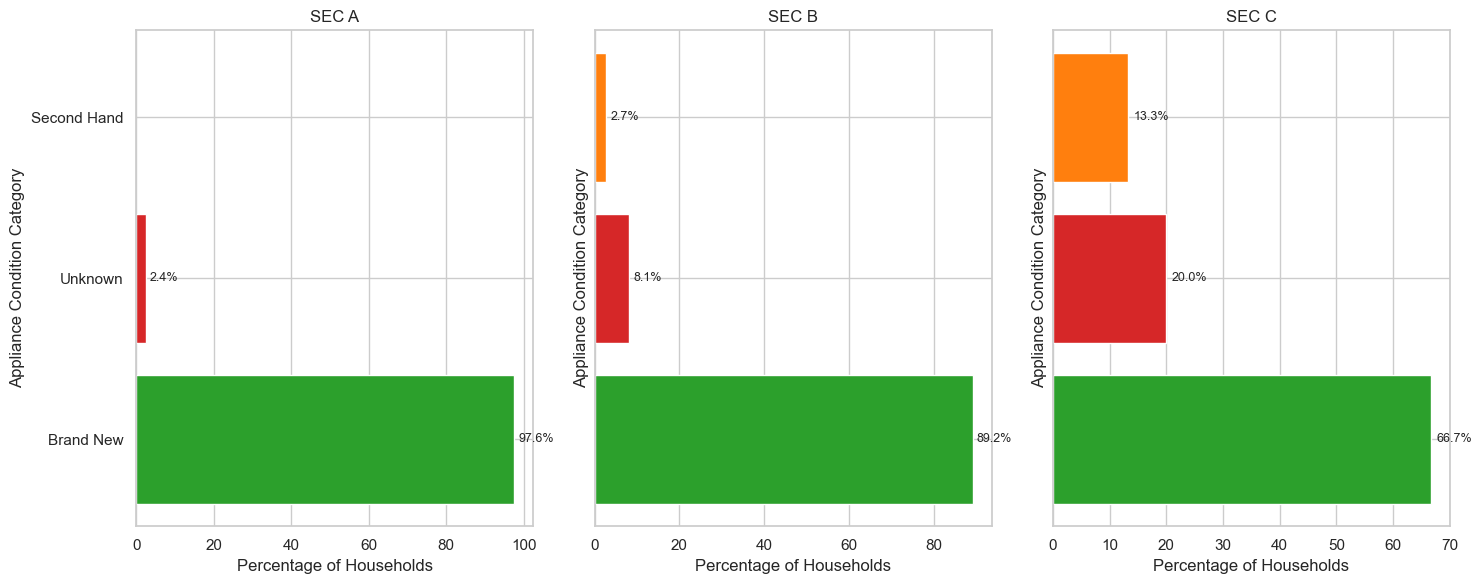


Summary of appliance condition distribution by SEC class:


,SEC_AGG,mode_appliance_condition,count,percentage
0,SEC A,Brand New,40,97.560976
1,SEC A,Unknown,1,2.439024
2,SEC B,Brand New,33,89.189189
3,SEC B,Second Hand,1,2.702703
4,SEC B,Unknown,3,8.108108
5,SEC C,Brand New,10,66.666667
6,SEC C,Second Hand,2,13.333333
7,SEC C,Unknown,3,20.000000



Saved -> household_mode_appliance_condition_by_SEC_percent.csv

Detailed appliance condition breakdown:

SEC A (Total households: 41):
  Brand New: 40 households (97.6%)
  Unknown: 1 households (2.4%)

SEC B (Total households: 37):
  Brand New: 33 households (89.2%)
  Second Hand: 1 households (2.7%)
  Unknown: 3 households (8.1%)

SEC C (Total households: 15):
  Brand New: 10 households (66.7%)
  Second Hand: 2 households (13.3%)
  Unknown: 3 households (20.0%)


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load appliance condition data ---
CONDITION_FILE = '/Users/ediritillekegeranushinimthara/Library/CloudStorage/OneDrive-LIRNEasia/Ranushi/Lacuna/vscode/wave_1/household_appliance_specifications_202509020921.csv'
condition_df = pd.read_csv(CONDITION_FILE, low_memory=False)

# Standardize column names
condition_df.columns = [c.strip().lower().replace(' ', '_') for c in condition_df.columns]

# Identify columns
hh_col_condition = next(c for c in condition_df.columns if 'household' in c and 'id' in c)
appliance_col_condition = next(c for c in condition_df.columns if 'appliance' in c and ('name' in c or c.endswith('appliance')))

# --- Keep only target appliances ---
target_appliances = [
    "TV",
    "Air Conditioner",
    "Washing Machine",
    "Fan",
    "Geyser / Hot water systems for bathrooms which operate from electricity",
    "Electric Water pump"
]

# Filter to target appliances
condition_subset = condition_df[condition_df[appliance_col_condition].isin(target_appliances)].copy()

# --- Combine condition1 and condition2 into a single condition column ---
def determine_condition(row):
    condition1 = str(row.get('condition1', '')).strip()
    condition2 = str(row.get('condition2', '')).strip()
    
    # Check if Brand New appears in condition1
    if 'Brand New' in condition1:
        return 'Brand New'
    # Check if Second Hand appears in condition2
    elif 'Second Hand' in condition2:
        return 'Second Hand'
    else:
        return 'Unknown'

condition_subset['appliance_condition'] = condition_subset.apply(determine_condition, axis=1)

# --- Filter to households identified as similar anomalous usage ---
condition_similar = condition_subset.merge(similar_df[['household_ID', 'SEC_AGG']], 
                                         left_on=hh_col_condition, right_on='household_ID', how='inner')

# --- Compute household-level mode of appliance condition ---
household_mode_condition = (
    condition_similar.groupby([hh_col_condition, 'SEC_AGG'])['appliance_condition']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
    .reset_index()
    .rename(columns={'appliance_condition':'mode_appliance_condition'})
)

# --- Count households per SEC and condition category ---
household_condition_count = (
    household_mode_condition.groupby(['SEC_AGG','mode_appliance_condition'])[hh_col_condition]
    .count()
    .rename('count')
    .reset_index()
)

# --- Convert counts to percentages within each SEC ---
household_condition_count['percentage'] = household_condition_count.groupby('SEC_AGG')['count'].transform(lambda x: 100 * x / x.sum())

# --- Plot percentages (horizontal bars) ---
classes = sorted(household_condition_count['SEC_AGG'].unique())
fig, axes = plt.subplots(1, len(classes), figsize=(5*len(classes), 6), sharey=True)
if len(classes) == 1:
    axes = [axes]

condition_order = ['Brand New', 'Second Hand', 'Unknown']
colors = {'Brand New': '#2ca02c', 'Second Hand': '#ff7f0e', 'Unknown': '#d62728'}

for ax, sec in zip(axes, classes):
    sub = household_condition_count[household_condition_count['SEC_AGG']==sec].copy()
    sub['mode_appliance_condition'] = pd.Categorical(sub['mode_appliance_condition'], categories=condition_order, ordered=True)
    sub = sub.sort_values('mode_appliance_condition')
    
    # Create color list for this subset
    sub_colors = [colors.get(cond, '#gray') for cond in sub['mode_appliance_condition']]
    
    # Horizontal bars: swap x and y
    bars = ax.barh(sub['mode_appliance_condition'], sub['percentage'], color=sub_colors)
    ax.set_title(f'{sec}')
    ax.set_xlabel('Percentage of Households')
    ax.set_ylabel('Appliance Condition Category')
    
    # Add percentage labels
    for bar, pct in zip(bars, sub['percentage']):
        if not np.isnan(pct) and pct > 0:
            ax.text(pct + 1, bar.get_y() + bar.get_height()/2, f'{pct:.1f}%', 
                   ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# --- Display summary table ---
print('\nSummary of appliance condition distribution by SEC class:')
display(household_condition_count)

# --- Optional: save table ---
household_condition_count.to_csv('household_mode_appliance_condition_by_SEC_percent.csv', index=False)
print('\nSaved -> household_mode_appliance_condition_by_SEC_percent.csv')

# --- Show detailed breakdown ---
print('\nDetailed appliance condition breakdown:')
for sec in classes:
    sec_data = household_condition_count[household_condition_count['SEC_AGG']==sec]
    total_households = sec_data['count'].sum()
    print(f'\n{sec} (Total households: {total_households}):')
    for _, row in sec_data.iterrows():
        print(f'  {row["mode_appliance_condition"]}: {row["count"]} households ({row["percentage"]:.1f}%)')

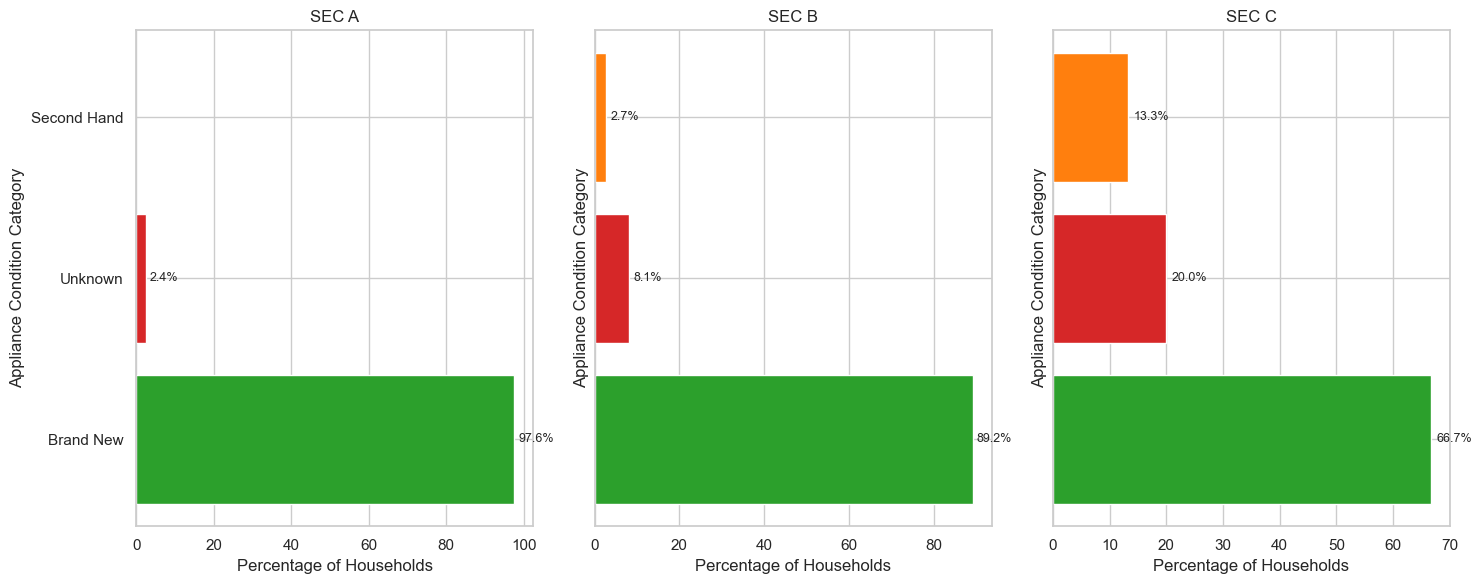


Summary of appliance condition distribution by SEC class:


,SEC_AGG,mode_appliance_condition,count,percentage
0,SEC A,Brand New,40,97.560976
1,SEC A,Unknown,1,2.439024
2,SEC B,Brand New,33,89.189189
3,SEC B,Second Hand,1,2.702703
4,SEC B,Unknown,3,8.108108
5,SEC C,Brand New,10,66.666667
6,SEC C,Second Hand,2,13.333333
7,SEC C,Unknown,3,20.000000



Saved -> household_mode_appliance_condition_by_SEC_percent.csv

Detailed appliance condition breakdown:

SEC A (Total households: 41):
  Brand New: 40 households (97.6%)
  Unknown: 1 households (2.4%)

SEC B (Total households: 37):
  Brand New: 33 households (89.2%)
  Second Hand: 1 households (2.7%)
  Unknown: 3 households (8.1%)

SEC C (Total households: 15):
  Brand New: 10 households (66.7%)
  Second Hand: 2 households (13.3%)
  Unknown: 3 households (20.0%)


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load appliance condition data ---
CONDITION_FILE = '/Users/ediritillekegeranushinimthara/Library/CloudStorage/OneDrive-LIRNEasia/Ranushi/Lacuna/vscode/wave_1/household_appliance_specifications_202509020921.csv'
condition_df = pd.read_csv(CONDITION_FILE, low_memory=False)

# Standardize column names
condition_df.columns = [c.strip().lower().replace(' ', '_') for c in condition_df.columns]

# Identify columns
hh_col_condition = next(c for c in condition_df.columns if 'household' in c and 'id' in c)
appliance_col_condition = next(c for c in condition_df.columns if 'appliance' in c and ('name' in c or c.endswith('appliance')))

# --- Keep only target appliances ---
target_appliances = [
    "TV",
    "Air Conditioner",
    "Washing Machine",
    "Fan",
    "Geyser / Hot water systems for bathrooms which operate from electricity",
    "Electric Water pump"
]

# Filter to target appliances
condition_subset = condition_df[condition_df[appliance_col_condition].isin(target_appliances)].copy()

# --- Combine condition1 and condition2 into a single condition column ---
def determine_condition(row):
    condition1 = str(row.get('condition1', '')).strip()
    condition2 = str(row.get('condition2', '')).strip()
    
    # Check if Brand New appears in condition1
    if 'Brand New' in condition1:
        return 'Brand New'
    # Check if Second Hand appears in condition2
    elif 'Second Hand' in condition2:
        return 'Second Hand'
    else:
        return 'Unknown'

condition_subset['appliance_condition'] = condition_subset.apply(determine_condition, axis=1)

# --- Filter to households identified as similar anomalous usage ---
condition_similar = condition_subset.merge(similar_df[['household_ID', 'SEC_AGG']], 
                                         left_on=hh_col_condition, right_on='household_ID', how='inner')

# --- Compute household-level mode of appliance condition ---
household_mode_condition = (
    condition_similar.groupby([hh_col_condition, 'SEC_AGG'])['appliance_condition']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
    .reset_index()
    .rename(columns={'appliance_condition':'mode_appliance_condition'})
)

# --- Count households per SEC and condition category ---
household_condition_count = (
    household_mode_condition.groupby(['SEC_AGG','mode_appliance_condition'])[hh_col_condition]
    .count()
    .rename('count')
    .reset_index()
)

# --- Convert counts to percentages within each SEC ---
household_condition_count['percentage'] = household_condition_count.groupby('SEC_AGG')['count'].transform(lambda x: 100 * x / x.sum())

# --- Plot percentages (horizontal bars) ---
classes = sorted(household_condition_count['SEC_AGG'].unique())
fig, axes = plt.subplots(1, len(classes), figsize=(5*len(classes), 6), sharey=True)
if len(classes) == 1:
    axes = [axes]

condition_order = ['Brand New', 'Second Hand', 'Unknown']
colors = {'Brand New': '#2ca02c', 'Second Hand': '#ff7f0e', 'Unknown': '#d62728'}

for ax, sec in zip(axes, classes):
    sub = household_condition_count[household_condition_count['SEC_AGG']==sec].copy()
    sub['mode_appliance_condition'] = pd.Categorical(sub['mode_appliance_condition'], categories=condition_order, ordered=True)
    sub = sub.sort_values('mode_appliance_condition')
    
    # Create color list for this subset
    sub_colors = [colors.get(cond, '#gray') for cond in sub['mode_appliance_condition']]
    
    # Horizontal bars: swap x and y
    bars = ax.barh(sub['mode_appliance_condition'], sub['percentage'], color=sub_colors)
    ax.set_title(f'{sec}')
    ax.set_xlabel('Percentage of Households')
    ax.set_ylabel('Appliance Condition Category')
    
    # Add percentage labels
    for bar, pct in zip(bars, sub['percentage']):
        if not np.isnan(pct) and pct > 0:
            ax.text(pct + 1, bar.get_y() + bar.get_height()/2, f'{pct:.1f}%', 
                   ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# --- Display summary table ---
print('\nSummary of appliance condition distribution by SEC class:')
display(household_condition_count)

# --- Optional: save table ---
household_condition_count.to_csv('household_mode_appliance_condition_by_SEC_percent.csv', index=False)
print('\nSaved -> household_mode_appliance_condition_by_SEC_percent.csv')

# --- Show detailed breakdown ---
print('\nDetailed appliance condition breakdown:')
for sec in classes:
    sec_data = household_condition_count[household_condition_count['SEC_AGG']==sec]
    total_households = sec_data['count'].sum()
    print(f'\n{sec} (Total households: {total_households}):')
    for _, row in sec_data.iterrows():
        print(f'  {row["mode_appliance_condition"]}: {row["count"]} households ({row["percentage"]:.1f}%)')

In [84]:
similar_df

,household_ID,SEC_AGG,num_appliances_compared,appliances_compared,k_std_used
0,ID0113,SEC A,4,"[TV, ac, Washing Machine, fan, Geyser / Hot wa...",1
1,ID0135,SEC A,2,"[TV, ac, Washing Machine, fan, Geyser / Hot wa...",1
2,ID0183,SEC A,4,"[TV, ac, Washing Machine, fan, Geyser / Hot wa...",1
3,ID0250,SEC A,4,"[TV, ac, Washing Machine, fan, Geyser / Hot wa...",1
4,ID0417,SEC A,4,"[TV, ac, Washing Machine, fan, Geyser / Hot wa...",1
...,...,...,...,...,...
124,ID3005,SEC C,1,"[TV, ac, Washing Machine, fan]",1
125,ID3225,SEC C,1,"[TV, ac, Washing Machine, fan]",1
126,ID3359,SEC C,2,"[TV, ac, Washing Machine, fan]",1
127,ID3427,SEC C,1,"[TV, ac, Washing Machine, fan]",1


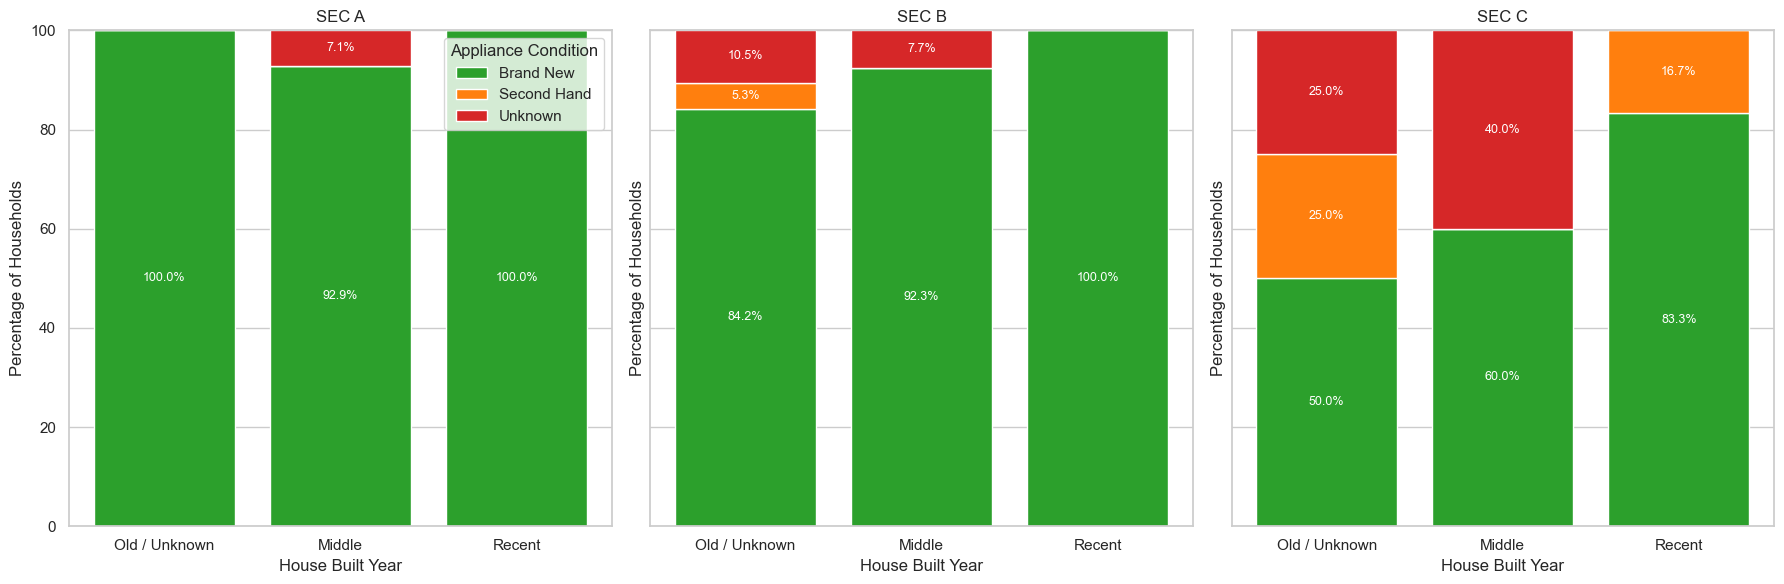

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Make column names consistent ---
household_mode_condition = household_mode_condition.rename(columns={hh_col_condition:'household_ID'})

# --- Merge household mode condition with built year ---
merged = pd.merge(
    household_mode_condition[['household_ID', 'SEC_AGG', 'mode_appliance_condition']],
    similar_info[['household_ID', 'SEC_AGG', 'built_year_cat']],
    on=['household_ID', 'SEC_AGG'],
    how='inner'
)

# --- Ensure category orders ---
condition_order = ['Brand New', 'Second Hand', 'Unknown']
built_order = ['Old / Unknown', 'Middle', 'Recent']

merged['mode_appliance_condition'] = pd.Categorical(
    merged['mode_appliance_condition'], categories=condition_order, ordered=True
)
merged['built_year_cat'] = pd.Categorical(
    merged['built_year_cat'], categories=built_order, ordered=True
)

# --- Plot stacked bars per SEC ---
secs = merged['SEC_AGG'].unique()
colors = {'Brand New':'#2ca02c', 'Second Hand':'#ff7f0e', 'Unknown':'#d62728'}

fig, axes = plt.subplots(1, len(secs), figsize=(6*len(secs),6), sharey=True)
if len(secs) == 1:
    axes = [axes]

for ax, sec in zip(axes, secs):
    sec_data = merged[merged['SEC_AGG']==sec]
    
    # Crosstab for this SEC (percentage within built year)
    cross_tab = pd.crosstab(
        index=sec_data['built_year_cat'],
        columns=sec_data['mode_appliance_condition']
    )
    cross_tab = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
    
    # Reindex to ensure all categories exist
    cross_tab = cross_tab.reindex(columns=condition_order, fill_value=0)
    cross_tab = cross_tab.reindex(built_order, fill_value=0)
    
    # Plot stacked bars
    bottom = pd.Series([0]*cross_tab.shape[0], index=cross_tab.index)
    for cond in cross_tab.columns:
        ax.bar(cross_tab.index, cross_tab[cond], bottom=bottom, color=colors[cond], label=cond)
        bottom += cross_tab[cond]
    
    ax.set_title(f"{sec}")
    ax.set_xlabel("House Built Year")
    ax.set_ylabel("Percentage of Households")
    
    # Add labels
    for i, built_year in enumerate(cross_tab.index):
        cumulative = 0
        for cond in cross_tab.columns:
            pct = cross_tab.loc[built_year, cond]
            if pct > 0:
                ax.text(
                    i, cumulative + pct/2,
                    f"{pct:.1f}%", ha='center', va='center', color='white', fontsize=9
                )
                cumulative += pct

axes[0].legend(title="Appliance Condition")
plt.tight_layout()
plt.show()


